# 1. Preamble
Import modules, define functions, etc...

In [1]:
%matplotlib qt

# standard imports as well as some additional ones for machine learning, plotting etc.
# farther down the cell are some functions 
import numpy as np
import pandas as pd
import math
import scipy.stats
from scipy.integrate import trapz
import scipy as sp
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from os import listdir
import sys
sys.path.append('../')
import SQ_calcs
import json
import os
%matplotlib inline
import glob
from collections import OrderedDict
import seaborn as sn
import random

import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn import metrics
import datetime as dt

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# make a new colormap interpolating between red and blue to encode MA fraction
n_points=501
comp_colors = []
for i in range(n_points):
    # append RGBA tuple
    comp_colors.append((i/n_points,0,1-i/n_points,1))
MA_cmp = ListedColormap(comp_colors)


#change default plot settings
mpl.style.use('wiley_publication.mplstyle')

## Useful functions used frequently defined below:



# return complement of a list (first) with respect to another (second)
def diff(first, second):
        second = set(second)
        return [item for item in first if item not in second]

# define function for handling marker styles when plotting to reflect 
# the environmental conditions used for a given data point
def envt_plot_style(temp,rh,o2,illum,encap):
   
    # currently assuming no experiments beyond 5 and 105 C
    if temp < 5:
        temp = 5
    if temp > 105:
        temp = 105
    
    if temp <= 25:
        m_color = np.array([0.00,0.00,0.20]) + (temp-5)/20*np.array([0,0.2,0])
    elif temp <= 45 and temp > 25 :
        m_color = np.array([0.00,0.20,0.20]) + (temp-25)/20*np.array([0,0,-0.2])
    elif temp <= 65 and temp > 45:
        m_color = np.array([0.00,0.20,0.00]) + (temp-45)/20*np.array([0.2,0,0])
    elif temp <= 85 and temp > 65:
        m_color = np.array([0.20,0.20,0.00]) + (temp-65)/20*np.array([0,-0.2,0])
    elif temp <=105 and temp > 85:
        m_color = np.array([0.20,0.00,0.00]) + (temp-85)/20*np.array([0,0,0.2])

    # humidity encoded by brightness
    m_color *= 1.75
    rh_factor = rh*0.65/100
    for x in range(len(m_color)):
        if m_color[x] != 0:
            m_color[x] += rh_factor

    # illumination encoded by marker shape
    if illum == 0:
        m_shape = 'p' # pentagons
    elif illum <= 0.5:
        m_shape = '^' # upright triangles
    elif illum <= 1:
        m_shape = 'v' # inverted triangles
    elif illum <= 2:
        m_shape = '8' # octagons
    elif illum <= 4:
        m_shape = 'h' # hexagons
    elif illum <= 8:
        m_shape = 'o' # circules
    elif illum <= 16:
        m_shape = 's' # squares
    elif illum <= 32:
        m_shape = 'D' # diamonds
        
    # oxygen level encoded by marker fill
    if o2 < 20:
        m_fill = 'none'
    elif o2 < 50:
        m_fill = 'right'
    else:
        m_fill = 'full'

    # encapsulation encoded by line style
    if encap == 'none':
        l_style = ' '
    elif encap == '5mgmL_PMMA':
        l_style = '--'
    elif encap == '10mgmL_PMMA':
        l_style = '-'
    else:
        l_style = ' '

    return m_color, m_shape, m_fill, l_style
  

# 2. Import Data/Calculate Physics-Inspired Features

In this block, read in the data, which has already been boiled down into features by a separate "featurizer" notebook that is somewhat time-consuming to run. From the raw environment and composition data in the featurized dataset, calculate physics-inspired features. 

In [2]:
# Read the CSV containing featurized data into the "featdata_df" DataFrame
readpath = ''
readname = 'Trial_Data/Film_Featurized_Data_for_Modeling.csv'
featdata_df = pd.read_csv(readpath+readname)

# Convert RH and %O2 to more partial pressures
T_gas = 25 # temperature of gas above the sample, in deg C
P_sat = 10**(8.07131 - 1730.63/(233.426 + T_gas)) # vapor pressure of H2O from Antoine equation [mm Hg]
featdata_df['P_H2O'] = 101325*featdata_df['RH (%)']/100*P_sat/760 # convert RH [%] to PH2O [Pa]
featdata_df['P_O2'] = 101325*featdata_df['Oxygen (%)']/100 # convert mole fraction of oxygen to PO2 [Pa]

# Add physics-inspired features

# adsorption energy for O2, eV
E_ads_O2_MAPI = -0.19
E_ads_O2_FACs = -0.10
E_ads_O2 = (E_ads_O2_FACs+(E_ads_O2_MAPI-E_ads_O2_FACs)*featdata_df['MA fraction'])*1.6e-19 # linear relationship based on composition

# adsorption energy for H2O, eV
E_ads_MAPI = -0.45
E_ads_FAPI = -0.27 
E_ads_H2O = (E_ads_FAPI+(E_ads_MAPI-E_ads_FAPI)*featdata_df['MA fraction'])*1.6e-19 # linear relationship based on composition

T_Kelvin = featdata_df['Temp (deg C)'] + 273.15 # convert temperature to K
h = 6.626e-34 # Planck's constant, J s
h_bar = h/(2*np.pi)
kB = 1.38e-23 # Boltzmann's constant, J/K

# calculate Langmuir isotherm for O2, using Keq following derivation in Schroeder
m_O2 = 16*1.67e-27 # approx. mass of O2 molecule, amu -> kg
eps_rot = 0.00018*1.6e-19 # rotational energy constant of O2 molecule, eV -> J
vQ_O2 = h**3*(2*np.pi*m_O2*kB*T_Kelvin)**(-3/2) # quantum volume of O2 [m3]
# equilibrium constant for O2 adsorption [1/Pa]
Keq_O2 = 2/3*eps_rot*h**3*(2*np.pi*m_O2)**(-3/2)*np.exp(-E_ads_O2/(kB*T_Kelvin))*(kB*T_Kelvin)**(-7/2)

# Langmuir adsorption isotherm for O2, as fractional surface coverage [unitless]
LAI_O2 = Keq_O2*featdata_df['P_O2']/(1+Keq_O2*featdata_df['P_O2'])     

# calculate Langmuir isotherm for H2O using empirical internal partition function...

# empirical relation for internal partition function of H2O from Tennyson and Vidler
a0 = -14.238481
a1 = 38.053703
a2 = -42.649044
a3 = 25.238163
a4 = -8.056219
a5 = 1.317839
a6 = -0.086023

# define function for internal partition function of H2O based on T&V values
Z_int_H2O = lambda T: 10**( a0*(np.log10(T))**0 + a1*(np.log10(T))**1 +\
                a2*(np.log10(T))**2 + a3*(np.log10(T))**3 +\
                a4*(np.log10(T))**4 + a5*(np.log10(T))**5 +\
                a6*(np.log10(T))**6 
              )

m_H2O = 18.02*1.67e-27 # mass of H2O [kg]
# equilibrium constant for H2O adsorption [1/Pa]
Keq_H2O = (h/np.sqrt(2*np.pi*m_H2O))**3*(kB*T_Kelvin)**(-5/2)/Z_int_H2O(T_Kelvin)*np.exp(-E_ads_H2O/(kB*T_Kelvin))

# Langmuir adsorption isotherm for O2, as fractional surface coverage [unitless]
LAI_H2O = Keq_H2O*featdata_df['P_H2O']/(1 + Keq_H2O*featdata_df['P_H2O'])

# activation energy for the photooxidation pathway, determined from a parabolic fit to the following:
# Ea(x_MA = 0) = 0.49 eV; Ea(x_MA = 0.5) = 0.9 eV; Ea(x_MA = 1) = 0.5 eV
x_meas = np.array([0,0.5,1]) # mole fraction
Ea_meas = np.array([0.49,0.9,0.5]) # activation energies, eV, from Arrhenius fits
Ea_fit = np.polyfit(x_meas,Ea_meas,2) # fit a parabola
x_fit = np.linspace(0,1,num=101)
#plt.plot(x_fit,Ea_fit[0]*x_fit**2 + Ea_fit[1]*x_fit + Ea_fit[2])
featdata_df['Ea_O2 (eV)'] = Ea_fit[0]*featdata_df['MA fraction']**2 + Ea_fit[1]*featdata_df['MA fraction'] + Ea_fit[2]

# rate constant for photooxidation, determined from a parabolic fit to the rate constants at 85C
ln_R0 = np.log(np.array([506.82, 8.5274e8, 2703.2]))
#ln_R0 = np.array([-9.65, -8.6, 2703.2])
R0_fit = np.polyfit(x_meas,ln_R0,2) # fit a parabola
#plt.plot(x_fit,R0_fit[0]*x_fit**2 + R0_fit[1]*x_fit + R0_fit[2])
PhOx_RC  = np.exp(R0_fit[0]*featdata_df['MA fraction']**2 + R0_fit[1]*featdata_df['MA fraction'] + R0_fit[2])


# assign calculated activation energy to DataFrame

# calculate electron concentration
me = 9.11e-31 # electron mass, kg
mc = 0.1*me # electron effective mass, kg
mv = 0.1*me # hole effective mass, kg
# CB and VB effective densities of states, 1/m3
Nc = 2*((mc*kB*(featdata_df['Temp (deg C)'].values+273.15))/(2*np.pi*h_bar**2))**(3/2)
Nv = 2*((mv*kB*(featdata_df['Temp (deg C)'].values+273.15))/(2*np.pi*h_bar**2))**(3/2)
Eg = 1.6 # perovskite band gap, eV
# intrinsic carrier density, 1/m3
ni = np.sqrt(Nc*Nv*np.exp(-Eg/(8.617e-5*(featdata_df['Temp (deg C)'].values+273.15))))
# excited carrier concentration, 1/m3
n_exc = ni*np.sqrt(np.exp(featdata_df['QFLS_0'].values/(8.617e-5*(featdata_df['Temp (deg C)'].values+273.15))))


# assign photooxidation and hydration rates to DataFrame

# non-dimensional photo-oxidation rate (Langmuir term * Arrhenius term)
gamma = 0.7
featdata_df['PhotoOx_rate'] = LAI_O2*(featdata_df['Illum (Nsuns)']**gamma)*np.exp(-featdata_df['Ea_O2 (eV)']/(8.617e-5*(featdata_df['Temp (deg C)']+273.15)))
# non-dimensional hydration rate Langmuir term * MA_fraction
featdata_df['Hydration_rate'] = LAI_H2O*(featdata_df['Illum (Nsuns)']**gamma)

# Entropy of Mixing calculation: 
xMA=featdata_df['MA fraction']           #MA mole fraction
xFA=0.83*(1-featdata_df['MA fraction'])  #FA mole fraction along the composition line we've been studying as 10/5/20 MUST CHANGE FOR MORE DIVERSE COMP SET
xCs=1-xMA-xFA                           #Cs mole fraction MUST CHANGE IF QUAD CATION COMPOSITIONS CONSIDERED

featdata_df['delS_mix'] = 0 # initalization step

for ii in range(len(xMA)):
    if xMA[ii]==1:
        featdata_df['delS_mix'].loc[ii] = 0 #no mixing, plus delS equation reduces to this anyway
    elif xMA[ii]==0:
        featdata_df['delS_mix'].loc[ii] = -(xFA[ii]*np.log(xFA[ii]) + xCs[ii]*np.log(xCs[ii]))  #deltaS mixing divided by number of moles and R
    else:
        featdata_df['delS_mix'].loc[ii] = -(xMA[ii]*np.log(xMA[ii]) + xFA[ii]*np.log(xFA[ii]) + xCs[ii]*np.log(xCs[ii]))  #deltaS mixing divided by number of moles and R

        
# calculate logarithm of selected features
featdata_df['lndTrdt'] = np.log(featdata_df['Bleach Rate (polyfit) (1/min)'])
featdata_df['ln|dTrdt|'] = np.log(np.abs(featdata_df['Bleach Rate (polyfit) (1/min)']))
featdata_df['lnPL80'] = np.log(featdata_df['PL_LD80'])
featdata_df['ln_r'] = np.log(featdata_df['deg_rate'])
featdata_df['|dAdt|'] = np.abs(featdata_df['dAdt'])
featdata_df['ln|dAdt|'] = np.log(np.abs(featdata_df['dAdt']))
featdata_df['ln|vol_rate|'] = np.log(np.abs(featdata_df['vol_rate']))


# optochemical parameters
alp_lin=9.61e4        
rho_mol=0.00671

# transform to measured rate 
featdata_df['meas_rate']   = featdata_df['|dAdt|'] * (100/60)      * (1e4*rho_mol/(np.log10(math.e)*alp_lin))/(featdata_df['Film Thickness [nm]']*1e-9)
# do the same for the derivative
featdata_df['d_meas_rate'] = featdata_df['ddA0']   * ((100/60)**2) * (1e4*rho_mol/(np.log10(math.e)*alp_lin))/(featdata_df['Film Thickness [nm]']*1e-9)


# and do logarithmic transformations
featdata_df['ln|meas_rate|'] = np.log(np.abs(featdata_df['meas_rate']))


# water-assisted and dry photooxidation parameters
kWPO = 2.9e-25
kDPO = 5.5e-15
EWPO = -0.09*1.6e-19
EDPO = 0.62*1.6e-19
K2_WPO = 2.3e-3
K2_DPO = 2.8e-3
K4_WPO = 9.1e-15
K4_DPO = 1.1e-15

# moisture-induced degradation parameters
khum = 9.2e-22
Ehum = 0.20*1.6e-19

# thermal decomposition parameters
ktherm = 0.00041
Etherm = 0.45*1.6e-19

# incident photon flux
inc_flux = SQ_calcs.one_sun_photon_flux(1.6)

# rate of water-assisted photooxidation
r_WPO = kWPO * np.exp(-EWPO/(kB*T_Kelvin)) \
             * (featdata_df['P_O2']/1000)*(featdata_df['P_H2O']/1000)*(inc_flux*featdata_df['Illum (Nsuns)'])**0.7 \
             / ( 1 + K2_WPO*(featdata_df['P_O2']/1000)*( 1 + K4_WPO*(inc_flux*featdata_df['Illum (Nsuns)'])**0.7) )**2

# rate of dry photooxidation
r_DPO = kDPO * np.exp(-EDPO/(kB*T_Kelvin)) \
             * (featdata_df['P_O2']/1000)*(inc_flux*featdata_df['Illum (Nsuns)'])**0.7 \
             / ( 1 + K2_DPO*(featdata_df['P_O2']/1000)*( 1 + K4_DPO*(inc_flux*featdata_df['Illum (Nsuns)'])**0.7) )

# rate of moisture-induced decomposition
r_hum = khum * np.exp(-Ehum/(kB*T_Kelvin)) \
        * rawdata_df['P_H2O']/1000 * (inc_flux*rawdata_df['Illum (Nsuns)'])**0.7

# rate of thermal decomposition
r_therm = ktherm * np.exp(-Etherm/(kB*T_Kelvin))

# grand sum over all pathways
featdata_df['MAPI_degrate'] = r_WPO + r_DPO + r_hum + r_therm
featdata_df['ln(MAPI_degrate)'] = np.log(featdata_df['MAPI_degrate'])
featdata_df['MAPI_volrate'] = featdata_df['MAPI_degrate']/featdata_df['Film Thickness [nm]']
featdata_df['ln(MAPI_volrate)'] = np.log(featdata_df['MAPI_volrate'])

encap = ''

C:\Users\Wiley\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Wiley\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# 3. Feature Pre-Selection

In this cell, set up the machine learning task by deciding which of the above attributes to use as the response (i.e., variable to predict) and which to use as the features and which to ignore. It is also possible to construct interaction-related features, such as those between environment and composition.

In [7]:
# change to True if using a log transform on the response
Log_transform = True
# change to True if recalculating coefficients after regularization
unshrink_coefficients = False

# choose the feature to use as the response
#response = 'tLD80 corrected (min)'
response = 'tLD80 (min)'
#response = 'tLD75 (min)'
#response = 'tLDmax'
#response = 'tPLmax'
#response = 'tA80'

# assign factor labels to certain features for brevity
factor_dict = {'A':'Temp (deg C)',
               'B':'RH (%)',
               'C':'Oxygen (%)',
               'D':'Illum (Nsuns)',
               'E':'MA fraction',
               'dTrdt':'Bleach Rate (polyfit) (1/min)',
               'dLDdt':'dLDdt (1/min)',
               'dPLdt':'dPLdt (1/min)',
               'LD0':'LD_0 (nm)',
               'PL0':'PLQY_0'}

factor_dict_inv = {'Temp (deg C)':'A',
                   'RH (%)':'B',
                   'Oxygen (%)':'C',
                   'Illum (Nsuns)':'D',
                   'MA fraction':'E',
                   'Bleach Rate (polyfit) (1/min)':'dTrdt',
                   'dLDdt (1/min)':'dLDdt',
                   'dPLdt (1/min)':'dPLdt',
                   'LD_0 (nm)':'LD0',
                   'PLQY_0':'PL0'}

# Features to use
chosen_features = [
                'Film Thickness [nm]',
                 'dTrdt',
                'lndTrdt',
                 'ddTr0',
                 'dLDdt',
                'dPLdt',
                'ddPL0',
                 'ddLD0',
                'ln(MAPI_degrate)',
                'MAPI_degrate',
                'ln(MAPI_volrate)',
                'MAPI_volrate',
                     'dtaudt',
                     'dmudt',
                     'ddmu0',
                     'ddtau0',
                      'LD0',
                       'PL0',
                 'A','P_O2','P_H2O','D','E',# linear environment and composition
                 'PhotoOx_rate','Hydration_rate','delS_mix', # physics-inspired features
]

# full dataset: features + response
terms_to_keep = chosen_features + [response]

# make a copy of the dataframe so that irrelevant responses can be removed
coded_df = featdata_df.copy()
print('Number of Runs Total:',len(coded_df))

# If what we are trying to predict is a failure time (e.g., tLD75, tPL10, etc.),
# throw out runs that fail before the prediction interval has finished
# or all runs that take 10 min or less
if response[0] == 't':
    coded_df = coded_df[coded_df['pred_horiz'] < coded_df[response]]
    #coded_df = coded_df[10 <= coded_df[response]]
print('Number of Runs That Fail After Prediction Horizon:',len(coded_df))

# encode feature names to simplify interaction calculations
coded_df.rename(columns = factor_dict_inv, inplace = True)
# drop responses that we're not interested in
cols_to_drop = diff(list(coded_df.columns),terms_to_keep)
coded_df = coded_df.drop(columns=cols_to_drop)


# drop rows containing NaNs
coded_df = coded_df.dropna(axis=0)
   
# display the modeling-ready dataset head    
coded_df.head()

Number of Runs Total: 275
Number of Runs That Fail After Prediction Horizon: 236


,Film Thickness [nm],A,D,E,dTrdt,dLDdt,dPLdt,LD0,PL0,ddTr0,...,P_H2O,P_O2,PhotoOx_rate,Hydration_rate,delS_mix,lndTrdt,MAPI_degrate,ln(MAPI_degrate),MAPI_volrate,ln(MAPI_volrate)
0,264,65.0,16.0,1.0,0.001699,0.010610,0.160090,113.682561,0.000446,0.000042,...,1304.224576,21278.25,4.129091e-14,0.002035,0.0,-6.377767,1.983445e-07,-15.433260,7.513050e-10,-21.009209
1,264,85.0,32.0,1.0,0.001650,-0.019268,-0.164830,93.007809,0.000179,0.000041,...,1910.546896,21278.25,9.940153e-14,0.001626,0.0,-6.406963,4.649316e-07,-14.581376,1.761105e-09,-20.157325
2,264,85.0,32.0,1.0,0.002153,0.009678,0.126625,108.820394,0.000104,-0.000009,...,1247.381858,21278.25,9.940153e-14,0.001062,0.0,-6.140707,4.276616e-07,-14.664934,1.619930e-09,-20.240883
3,264,85.0,32.0,1.0,0.002377,-0.017767,0.161300,103.198333,0.000178,0.000124,...,1872.651751,21278.25,9.940153e-14,0.001594,0.0,-6.041872,4.628019e-07,-14.585967,1.753037e-09,-20.161916
4,264,85.0,32.0,1.0,0.001565,-0.018229,-0.207889,99.524614,0.000288,0.000066,...,783.166331,21278.25,9.940153e-14,0.000667,0.0,-6.460172,4.015727e-07,-14.727877,1.521109e-09,-20.303826


# 4. Modeling

In this cell, the machine learning model is initialized and trained. Error metrics and coefficients are calculated and tabulated for visualization in the cells below.

{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.039810717055349734}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.01584893192461114}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.06309573444801933}


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}
For test set:
Mean of Mean Absolute Error = 13.3 %
Median of Mean Absolute Error = 9.1 %
Std. Dev. of Mean Absolute Error = 14.8 %
Mean of Mean Absolute Error = 0.577
Median of Mean Absolute Error = 0.416
Std. Dev. of Mean Absolute Error = 0.548
Mean R2 = nan
Median R2 = nan
Std Dev. R2 = nan
For whole model:
Mean of Mean Absolute Error = 11.5 %
Median of Mean Absolute Error = 11.4 %
Std. Dev. of Mean Absolute Error = 0.3 %
Mean of Mean Absolute Error = 0.506
Median of Mean Absolute Error = 0.501
Std. Dev. of Mean Absolute Error = 0.007
Mean R2 = 0.7202
Median R2 = 0.7281
Std Dev. R2 = 0.0113
Mean Linear Error = 85.7 %
Median Linear Error = 41.9 %
Index of Median Model: 39


C:\Users\Wiley\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


{'alpha': 0.025118864315095808}


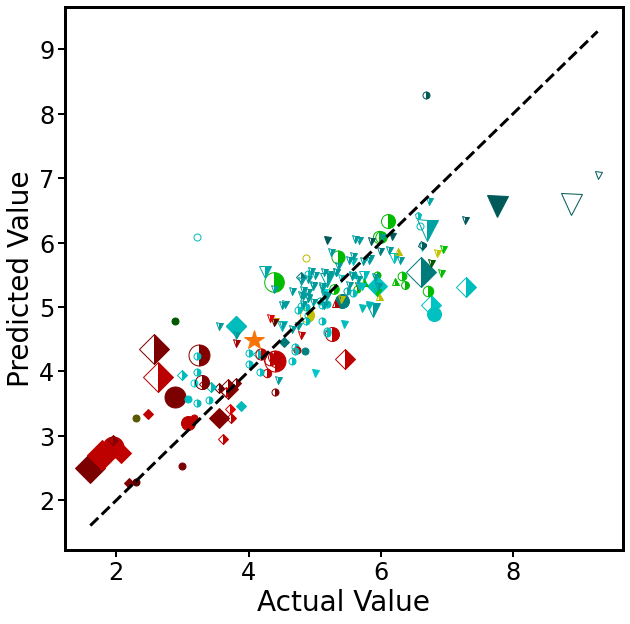

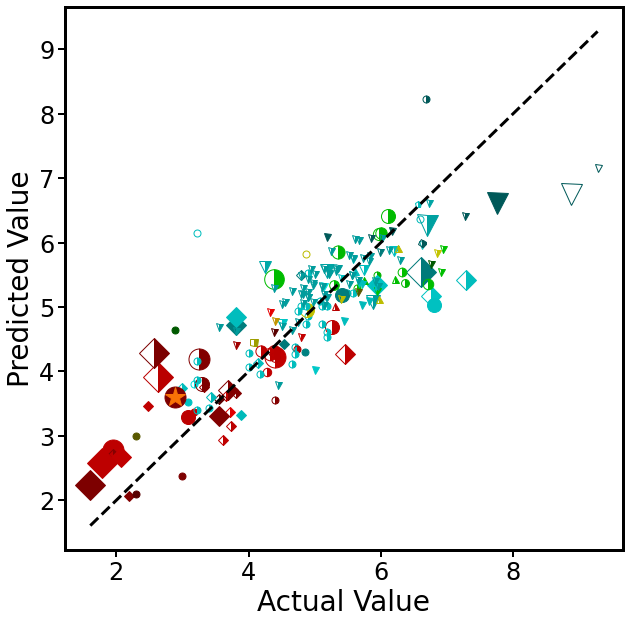

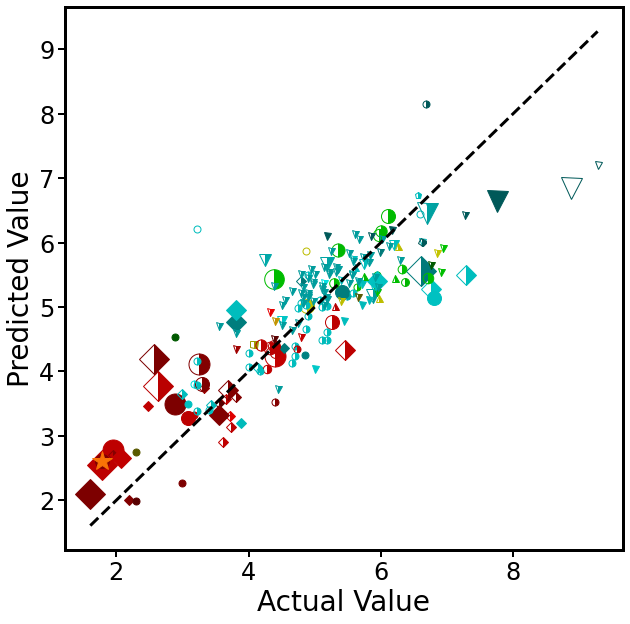

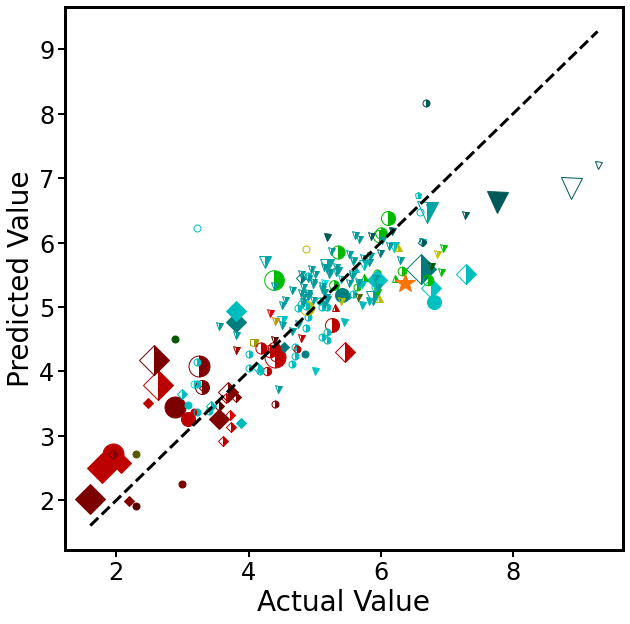

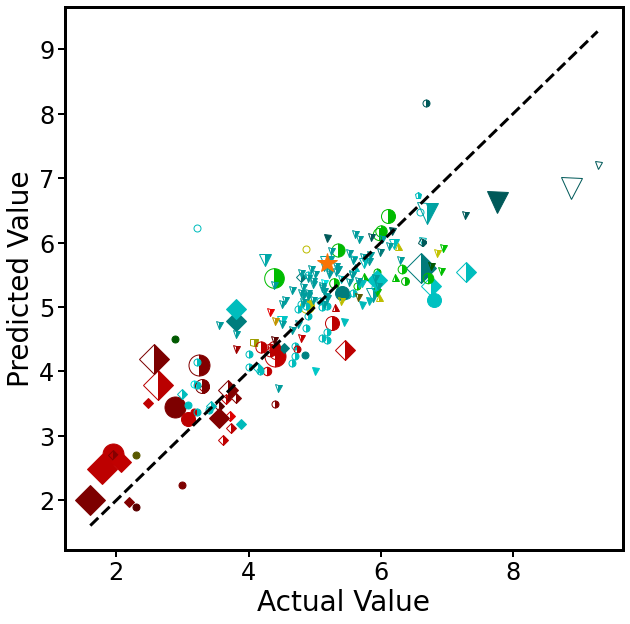

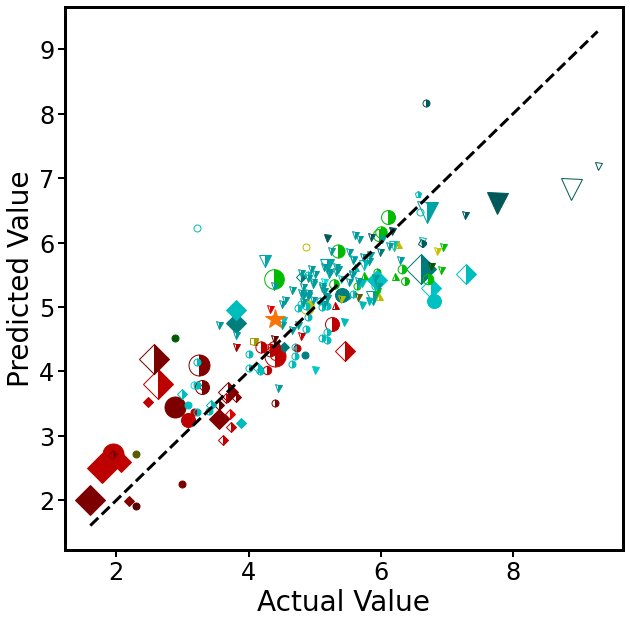

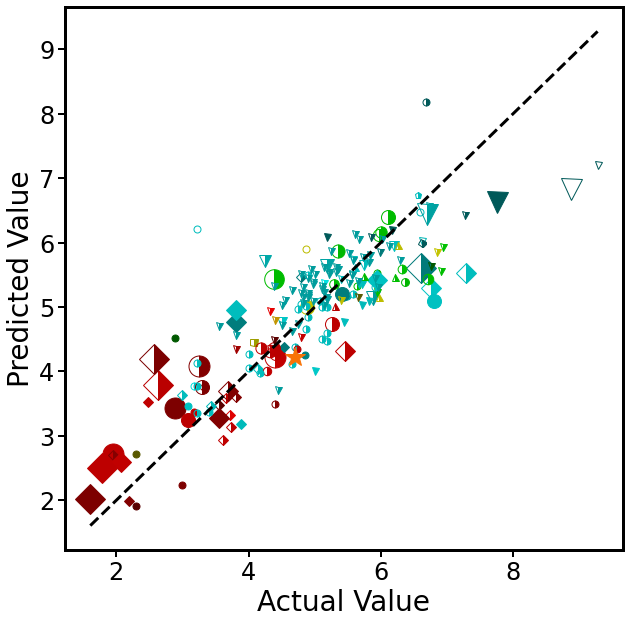

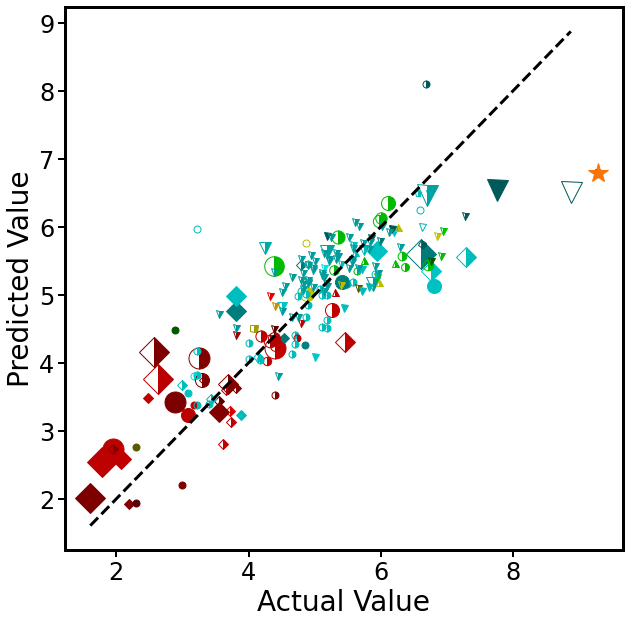

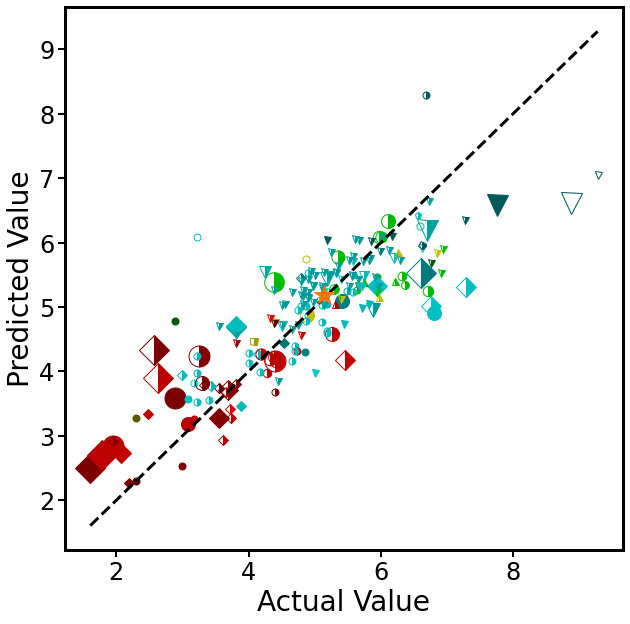

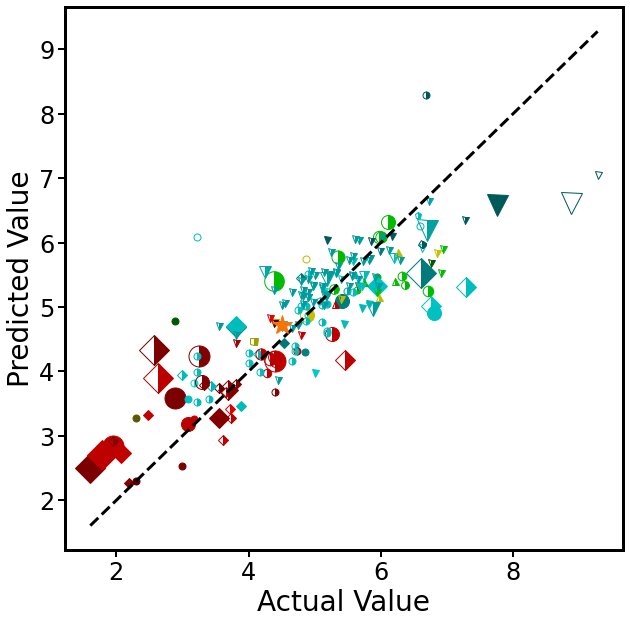

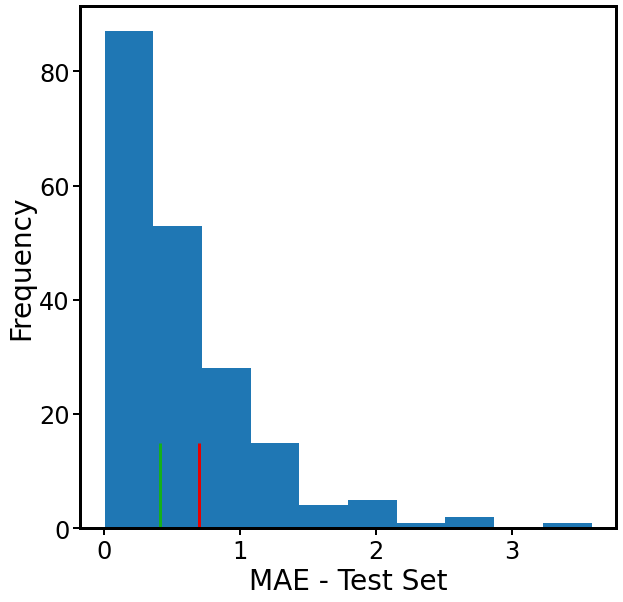

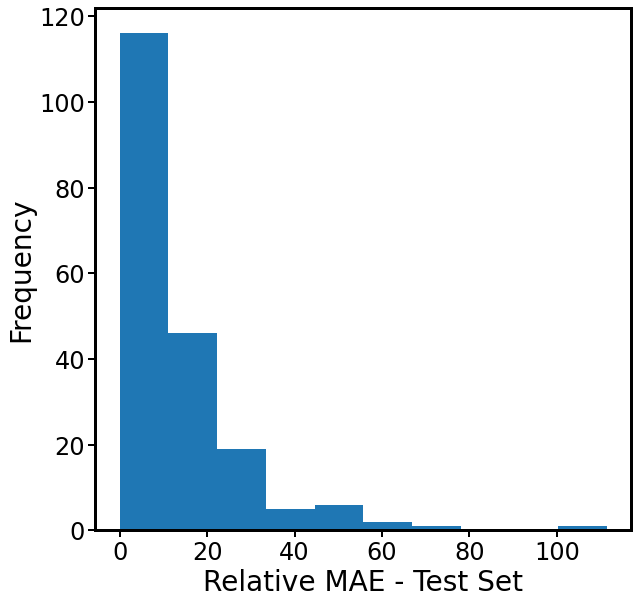

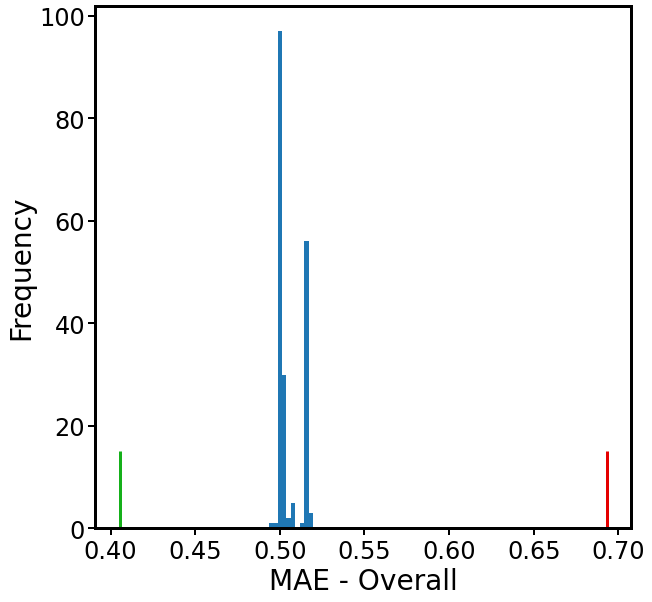

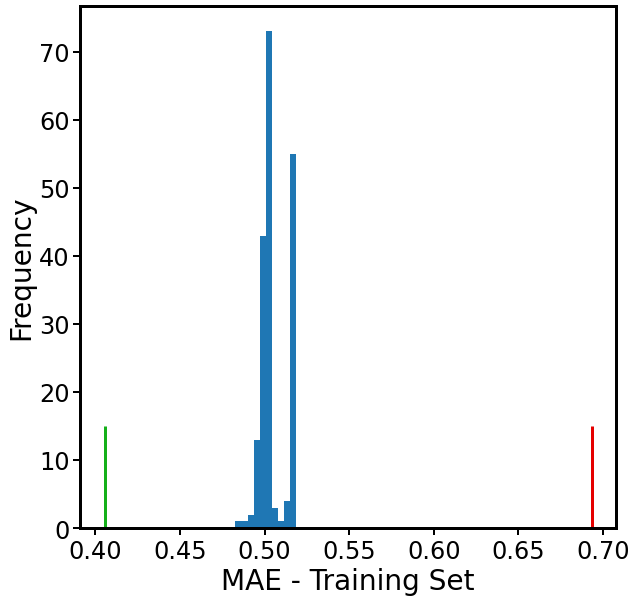

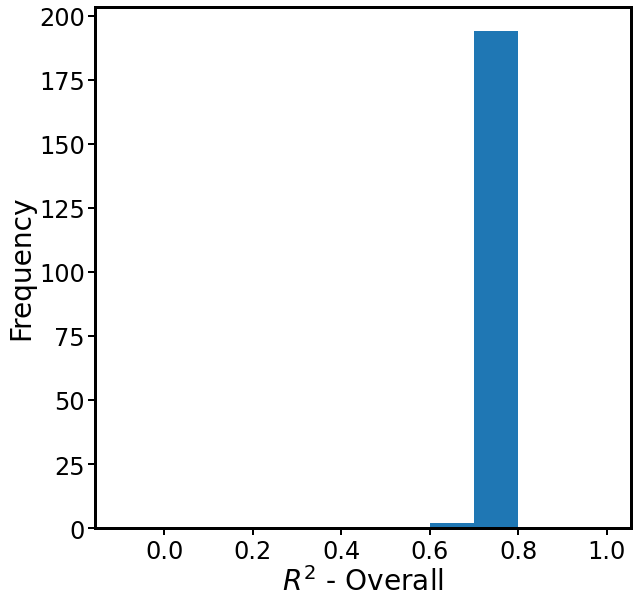

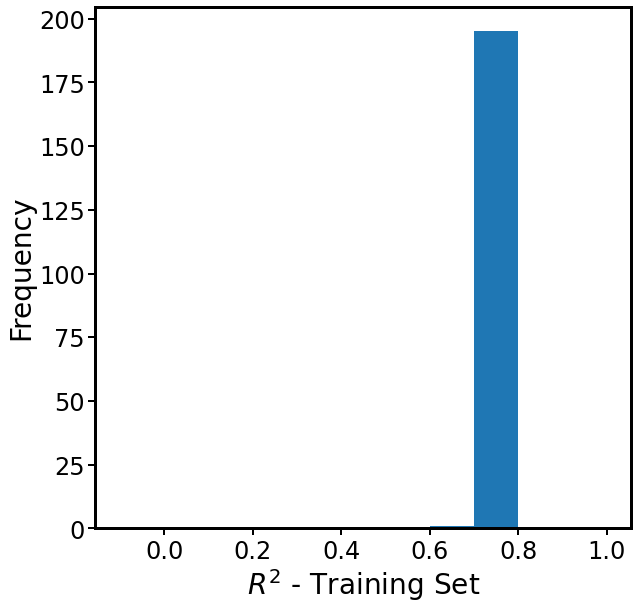

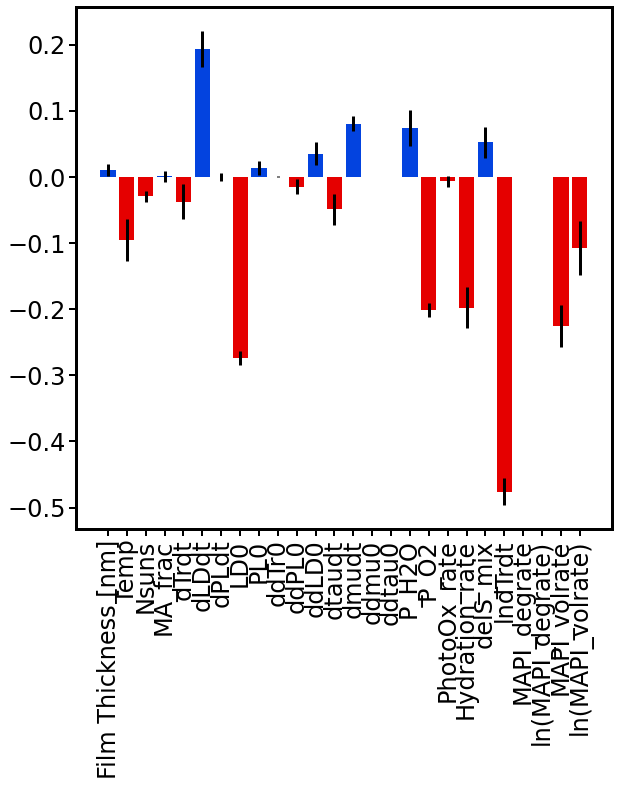

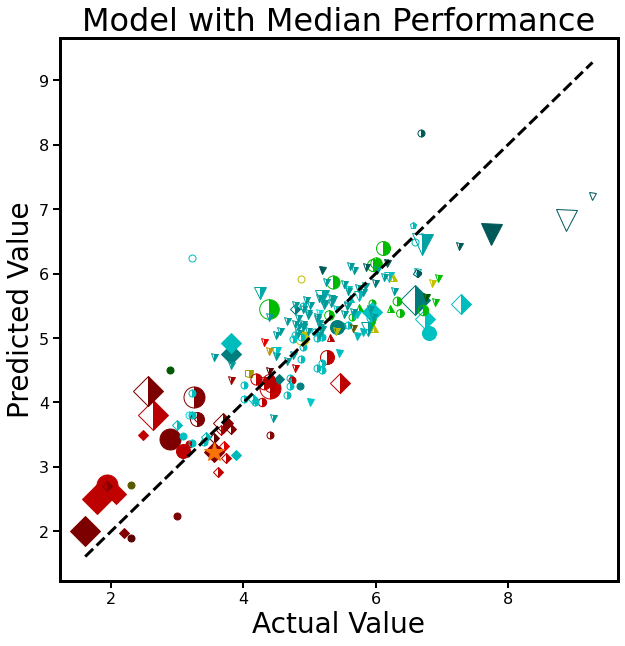

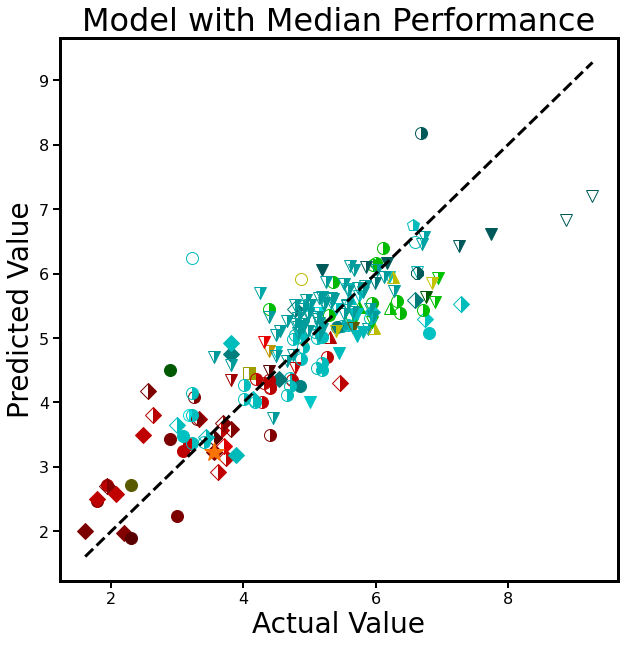

In [8]:
# try some machine learning in this cell - LASSO with leave one out testing [test cell]
# DISCLAIMER: be very careful when mixing pandas and sklearn - some of the canned functions from sklearn take in 
# DataFrames but spit out arrays. Indexing can become a mess if rows have been removed from the DF during data cleaning
# because the indices will no longer sync up between the DFs and the output array. (This can happen when using the 
# .dropna() method to remove runs that do not go to LD,75, for instance.) 

# first determine whether to do a log transform on the response or not, 
# then partition the data into features (X) and response (Y) DFs
if Log_transform:
    Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
else:
    Y = coded_df[response].copy()
X = coded_df.drop(columns=response).copy()

# number of runs in dataset - for leave-one-out testing this is the size of the dataset
n_trials = len(Y)

# set up search parameters for cross-validation, which will be used to select the hyperparameter
param_vals = np.logspace(-3,1,num=21) # range of hyperparameters to test
parameters = {'alpha': param_vals}
model = Lasso(max_iter=1e9) # model to implement - LASSO, Ridge, etc.
metric = 'neg_mean_absolute_error' # scoring metric - MSE, R2, etc.
folds = n_trials-1 # how many folds to do in k-fold cross-validation - 5 is standard
folds = 10

# initialize error metrics for test set...
R2 = np.zeros(n_trials) # coefficient of determination
RMSE = np.zeros(n_trials) # RMS error
MAE_pct = np.zeros(n_trials) # mean absolute error, percent
MAE_pct_signed = np.zeros(n_trials) # mean absolute error, percent with sign
MAE = np.zeros(n_trials) # mean absolute error

# ...and for the whole dataset...
MAE_pct_overall = np.zeros(n_trials) # mean absolute error, percent
MAE_overall = np.zeros(n_trials) # mean absolute error, percent
R2_overall = np.zeros(n_trials) # coefficient of determination

# ...and for the training set
MAE_pct_train = np.zeros(n_trials) # mean absolute error, percent
MAE_train = np.zeros(n_trials) # mean absolute error, percent
R2_train = np.zeros(n_trials) # coefficient of determination

# error on linear scale (only relevant if log transform is used on response, but we do this a lot)
linear_error = np.zeros(n_trials)

# initialize a dataframe to keep track of model coefficients on every iteration of the test set loop
coeffs_df = pd.DataFrame(columns=coded_df.drop(columns=response).columns)
# keep track of feature standardization values too
means_array = np.zeros([n_trials,len(coded_df.drop(columns=response).columns)])
stds_array = np.zeros([n_trials,len(coded_df.drop(columns=response).columns)])
# make a list to keep track of model bias term
model_intercepts = []
# keep track of Shapley values too
Shap_vals_df =  pd.DataFrame(columns=coded_df.drop(columns=response).columns)
# keep track of *change in* error with feature deleted relative to model with the full feature set
d_error_missing_feats = []

# outer loop: hold one sample out for testing every iteration
for kk in range(n_trials):
    
    # do test/train split by pulling out one row at a time form the feature and response DFs
    # CAREFUL WITH THE INDEXING - note differences between the test/withhold and training sets
    # ALSO: COPY THE SUBSETS Of THE DATAFRAMES or the values in the source will change and the 
    # prediction will be unstable and the whole thing will be ruined
    X_whold = X.iloc[kk].copy()
    y_whold = Y.iloc[kk:kk+1].copy()
    X_train = X.drop(X.index[kk]).copy()
    y_train = Y.drop(X.index[kk]).copy()
    
    # standardize the data according to the mean and variance of each feature in the training dataset
    for nn,col in enumerate(X_train.columns):
        # get mean and variance of features in the test set
        col_mean = np.mean(X_train[col])
        col_std = np.std(X_train[col])
        # standardize the features in the training set
        z_train = (X_train[col] - col_mean)/col_std
        X_train[col] = z_train
        # standardize the features in the test set
        z_whold = (X_whold[col] - col_mean)/col_std
        X_whold[col] = z_whold
        means_array[kk,nn] = col_mean
        stds_array[kk,nn] = col_std
        
    
    # cross-validation step to set alpha/lambda/penalty hyperparameter
    regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
    regressor.fit(X_train,y_train)
    
    # print winning HP value if desired...
    print(regressor.best_params_)
    #print(regressor.best_score_)
    alpha = regressor.best_params_['alpha']
    
    # ...and retrain the final model on the full training set
    final_model = Lasso(alpha=alpha)
    final_model.fit(X_train,y_train)
    #print(final_model.coef_)
    
    # if desired, recalculate the coefficients:
    if unshrink_coefficients:
        
        # figure out which coefficients survived
        surviving_coeffs = X.columns[np.where(final_model.coef_ != 0)]
        
        # make a copy of the training set with rejected coefficients stripped out
        X_red = X_train.copy()
        X_red = X_red[surviving_coeffs]
        X_whold_red = X_whold.copy()
        X_whold_red = X_whold_red[surviving_coeffs]
        # retrain the final model
        
        # train a simple linear regression
        shrunk_model = sklearn.linear_model.LinearRegression()
        shrunk_model.fit(X_red,y_train)
        
        # and fit the data
        ypred=shrunk_model.predict(np.array(X_whold_red).reshape(1,-1))
        ytpred=shrunk_model.predict(X_red)
    
    else:
        # make predictions on the test and training data
        ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
        ytpred=final_model.predict(X_train)
    
    # calculate error metrics on test set
    RMSE[kk] = np.sqrt(metrics.mean_squared_error(np.array(y_whold).reshape(1,-1), ypred))
    R2[kk] = metrics.r2_score(np.array(y_whold).reshape(1,-1), ypred)
    MAE_pct[kk] = np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100)
    MAE_pct_signed[kk] = (y_whold-ypred)/y_whold*100
    MAE[kk] = np.mean(np.abs(y_whold-ypred))
    
    # put the whole dataset back together (note that this will create arrays, not DFs)
    y_net = np.concatenate([y_train,y_whold])
    y_pred_net = np.concatenate([ytpred,ypred])
    
    # calculate error metrics on entire set
    R2_overall[kk] = metrics.r2_score(y_net, y_pred_net)
    MAE_overall[kk] = np.mean(np.abs(y_net-y_pred_net))
    MAE_pct_overall[kk] = np.mean(np.abs(y_net-y_pred_net)/np.abs(y_net)*100)
    
    # calculate error metrics on training set
    R2_train[kk] = metrics.r2_score(y_train, ytpred)
    MAE_train[kk] = np.mean(np.abs(y_train-ytpred))
    MAE_pct_train[kk] = np.mean(np.abs(y_train-ytpred)/np.abs(y_train)*100)
    
    # calculate linear error metric
    linear_error[kk] = np.abs(np.exp(y_whold) -  np.exp(ypred))/np.exp(y_whold)*100
    
    # plot training data with markers corresponding to environmental + compositional conditions
    if kk%20 == 0: # only do this for a few models to save memory
        
        plt.figure(figsize=(10,10))
        for ii in range(len(y_train)):
            idx = y_train.index[ii] # pull the corresponding index in the DF
            T = featdata_df['Temp (deg C)'][idx] # get temperature
            RH = featdata_df['RH (%)'][idx] # get relative humidity
            pct_O2 = featdata_df['Oxygen (%)'][idx] # get oxygen mole fraction
            N_suns_stress = featdata_df['Illum (Nsuns)'][idx] # get illumination
            color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
            MA_frac = featdata_df['MA fraction'][idx] # get composition
            # and plot
            plt.plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
            # plt.text(y_train.loc[idx],ytpred[ii],idx) # ERROR checking: plot the index value
            
        # plot perfect prediction line and +/-50% error bounds
        plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
        plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
        #plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
        #plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')
        
        # put labels on the axes
        plt.xlabel('Actual Value')
        plt.ylabel('Predicted Value')

        # plot test data as above
        for ii in range(len(y_whold)):
            idx = y_whold.index[ii] # pull the corresponding index in the DF
            T = featdata_df['Temp (deg C)'][idx] # get temperature
            RH = featdata_df['RH (%)'][idx] # get relative humidity
            pct_O2 = featdata_df['Oxygen (%)'][idx] # get oxygen mole fraction
            N_suns_stress = featdata_df['Illum (Nsuns)'][idx] # get illumination
            color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
            MA_frac = featdata_df['MA fraction'][idx] # get composition
            plt.plot(y_whold[idx],ypred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
            # plot orange star to identify test samples
            plt.plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange')                
    
    # save the model coefficients to the respective row in the DF
    if unshrink_coefficients:
        # reconstruct the full model coefficients
        coeffs_vector = np.zeros(len(final_model.coef_))
        count = 0
        for ii in range(len(final_model.coef_)):
            if final_model.coef_[ii] != 0:
                coeffs_vector[ii] = shrunk_model.coef_[count]
                count += 1
        coeffs_df = coeffs_df.append(pd.DataFrame(coeffs_vector.reshape(1,len(final_model.coef_)),
                                                  columns=coded_df.drop(columns=response).columns))


    else:
        coeffs_df = coeffs_df.append(pd.DataFrame(final_model.coef_.reshape(1,len(final_model.coef_)),columns=coded_df.drop(columns=response).columns))

    model_intercepts.append(final_model.intercept_)
    
        
    # calculate and save Shapley values
    shap_vals = final_model.coef_.reshape(1,len(final_model.coef_))*(np.array(X_whold)-np.mean(np.array(X_train),axis=0))
    Shap_vals_df = Shap_vals_df.append(pd.DataFrame(shap_vals,columns=coded_df.drop(columns=response).columns))
    
    # sensitivity analysis for feature removal
    sensitivity_analysis = False
    
    if sensitivity_analysis:
        # re-initialize a list for keeping track of error with feature deleted
        d_error_missing_feats_per_obv = []

        # loop over features
        for col in X_train.columns:

            # drop each feature
            X_train_reduced = X_train.drop(columns=col).copy()
            X_whold_reduced = X_whold.drop(col).copy()

            # set alpha/lambda/penalty hyperparameter
            regressor.fit(X_train_reduced,y_train)
            alpha = regressor.best_params_['alpha']

            # train the final model on the full training set
            final_model_red = Lasso(alpha=alpha)
            final_model_red.fit(X_train_reduced,y_train)

            # make predictions on the test and training data
            ypred=final_model_red.predict(np.array(X_whold_reduced).reshape(1,-1))

            # calculate error metrics on test set with the missing feature
            # and append it to the error list
            d_error_missing_feats_per_obv.append(np.mean(np.abs(y_whold-ypred)/np.abs(y_whold)*100) - MAE_pct[kk])

    if sensitivity_analysis:    
        # save the error with deleted features
        d_error_missing_feats.append(d_error_missing_feats_per_obv)

if sensitivity_analysis:
    # convert the change in error with missing features to a dataframe from epi-list
    missing_feats_DF = pd.DataFrame(d_error_missing_feats,columns=coded_df.drop(columns=response).columns)    

# plot histogram of absolute test set error
plt.figure()
plt.hist(MAE)
plt.xlabel('MAE - Test Set')
plt.ylabel('Frequency')
plt.vlines(-np.log(0.5),ymin=0,ymax=15,color='xkcd:red')
plt.vlines(np.log(1.5),ymin=0,ymax=15,color='xkcd:green')

# plot histogram of percent test set error
plt.figure()
plt.hist(MAE_pct)
plt.xlabel('Relative MAE - Test Set')
plt.ylabel('Frequency')

# plot histogram of absolute full set error
plt.figure()
plt.hist(MAE_overall)
plt.xlabel('MAE - Overall')
plt.ylabel('Frequency')
plt.vlines(-np.log(0.5),ymin=0,ymax=15,color='xkcd:red')
plt.vlines(np.log(1.5),ymin=0,ymax=15,color='xkcd:green')

# plot histogram of absolute training set error
plt.figure()
plt.hist(MAE_train)
plt.xlabel('MAE - Training Set')
plt.ylabel('Frequency')
plt.vlines(-np.log(0.5),ymin=0,ymax=15,color='xkcd:red')
plt.vlines(np.log(1.5),ymin=0,ymax=15,color='xkcd:green')

# plot histogram of full set R2
plt.figure()
plt.hist(R2_overall,bins=np.linspace(-0.1,1,num=12))
plt.xlabel('$R^2$ - Overall')
plt.ylabel('Frequency')

# plot histogram of training set R2
plt.figure()
plt.hist(R2_train,bins=np.linspace(-0.1,1,num=12))
plt.xlabel('$R^2$ - Training Set')
plt.ylabel('Frequency')

# plot distribution of coefficients...
plt.figure()

# convert labels "A", "B", etc. back to physically meaningful names
new_dict = {
    "A":"Temp",
    "B":"RH",
    'C':'O2',
    'D':'Nsuns',
    'E':'MA_frac'
}
coeffs_df.rename(columns = new_dict, inplace = True)

# populate standardization values
coeffs = coeffs_df.columns # save coefficient names
means_df = pd.DataFrame(means_array,columns=coeffs)
stds_df = pd.DataFrame(stds_array,columns=coeffs)


# add intercepts and rename coefficients
#coeffs_df['intercepts'] = model_intercepts
coeffs = coeffs_df.columns # save coefficient names

avgs = np.mean(coeffs_df) # average the coefficients
error = np.std(coeffs_df) # and get their standard deviations



# assign colors to coefficient bars based on sign:
# red: accelerates degradation
# blue: decelerates degradation
# (these have different signs depending on what the response is)
bar_colors = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors.append('xkcd:red')
        else:
            bar_colors.append('xkcd:blue')
else:
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors.append('xkcd:blue')
        else:
            bar_colors.append('xkcd:red')

# plot the coefficients
plt.bar(coeffs,avgs,yerr=error,color=bar_colors)
plt.xticks(rotation=90) # make the labels legible

# Print important test statistics
print('For test set:')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_pct),1), '%')
print('Median of Mean Absolute Error =', np.round(np.median(MAE_pct),1), '%')
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_pct),1), '%')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE),3))
print('Median of Mean Absolute Error =', np.round(np.median(MAE),3))
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE),3))
print('Mean R2 =', np.round(np.mean(R2),4))
print('Median R2 =', np.round(np.median(R2),4))
print('Std Dev. R2 =', np.round(np.std(R2),4))

print('For whole model:')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_pct_overall),1), '%')
print('Median of Mean Absolute Error =', np.round(np.median(MAE_pct_overall),1), '%')
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_pct_overall),1), '%')
print('Mean of Mean Absolute Error =', np.round(np.mean(MAE_overall),3))
print('Median of Mean Absolute Error =', np.round(np.median(MAE_overall),3))
print('Std. Dev. of Mean Absolute Error =', np.round(np.std(MAE_overall),3))
print('Mean R2 =', np.round(np.mean(R2_overall),4))
print('Median R2 =', np.round(np.median(R2_overall),4))
print('Std Dev. R2 =', np.round(np.std(R2_overall),4))

print('Mean Linear Error =',np.round(np.mean(linear_error),1),'%')
print('Median Linear Error =',np.round(np.median(linear_error),1),'%')


##### Below this line is the code for plotting the performance of the median model

# identify the index corresponding to the median mean test error
idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
med_idx = idx # save the median index in a less ambiguous form
print('Index of Median Model:',idx)

# partition the dataset - note the manipulations necessary to convert the index derived from 
# the test error array to the index of the DataFrame - THESE VALUES ARE DIFFERENT!
kk = idx
X_whold = X.iloc[kk].copy()
y_whold = Y.iloc[kk:kk+1].copy()
X_train = X.drop(X.index[kk]).copy()
y_train = Y.drop(X.index[kk]).copy()



# standardize the data according to the mean and variance of the training dataset
for col in X_train.columns:
    # get mean and variance of features in the test set
    col_mean = np.mean(X_train[col])
    col_std = np.std(X_train[col])
    # standardize the features in the training set
    z_train = (X_train[col] - col_mean)/col_std
    X_train[col] = z_train
    # standardize the features in the test set
    z_whold = (X_whold[col] - col_mean)/col_std
    X_whold[col] = z_whold
    

# cross-validation step to set alpha/lambda/penalty hyperparameter
regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
regressor.fit(X_train,y_train)

# print winning HP value if desired...
print(regressor.best_params_)
#print(regressor.best_score_)
alpha = regressor.best_params_['alpha']

# and retrain the final model on the full training set
final_model = Lasso(alpha=alpha)
final_model.fit(X_train,y_train)
#print(final_model.coef_)

if unshrink_coefficients:

    # figure out which coefficients survived
    surviving_coeffs = X.columns[np.where(final_model.coef_ != 0)]

    # make a copy of the training set with rejected coefficients stripped out
    X_red = X_train.copy()
    X_red = X_red[surviving_coeffs]
    X_whold_red = X_whold.copy()
    X_whold_red = X_whold_red[surviving_coeffs]
    # retrain the final model

    # train a simple linear regression
    shrunk_model = sklearn.linear_model.LinearRegression()
    shrunk_model.fit(X_red,y_train)

    # and fit the data
    ypred=shrunk_model.predict(np.array(X_whold_red).reshape(1,-1))
    ytpred=shrunk_model.predict(X_red)

else:
    # make predictions on the test and training data
    ypred=final_model.predict(np.array(X_whold).reshape(1,-1))
    ytpred=final_model.predict(X_train)

####### PLOT THE MEDIAN MODEL ##############

plt.figure(figsize=(10,10))
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    T = featdata_df['Temp (deg C)'][idx]
    RH = featdata_df['RH (%)'][idx]
    pct_O2 = featdata_df['Oxygen (%)'][idx]
    N_suns_stress = featdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    #MA_frac = X[factor_dict_inv['MA fraction']][idx]
    MA_frac = featdata_df['MA fraction'][idx]
    plt.plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
    #plt.text(y_train.loc[idx],ytpred[ii],idx)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Model with Median Performance')

# plot test data as above, with environment denoted by marker appearance and composition by marker size
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    T = featdata_df['Temp (deg C)'][idx]
    RH = featdata_df['RH (%)'][idx]
    pct_O2 = featdata_df['Oxygen (%)'][idx]
    N_suns_stress = featdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = featdata_df['MA fraction'][idx]
    plt.plot(y_whold[idx],ypred[ii],color=color,marker=marker,markersize=14*(1.5-MA_frac),fillstyle=fill,linestyle=style)
    plt.plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange') 
    
####### PLOT THE MEDIAN MODEL - ALTERNATIVE STYLE ##############
# i.e., separate plots encoding environment and composition

plt.figure(figsize=(10,10))
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    T = featdata_df['Temp (deg C)'][idx]
    RH = featdata_df['RH (%)'][idx]
    pct_O2 = featdata_df['Oxygen (%)'][idx]
    N_suns_stress = featdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = featdata_df['MA fraction'][idx]
    plt.plot(y_train.loc[idx],ytpred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
    #plt.text(y_train.loc[idx],ytpred[ii],idx)

# plot perfect prediction line and +/-50% error bounds
plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
plt.plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#plt.plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Model with Median Performance')

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    T = featdata_df['Temp (deg C)'][idx]
    RH = featdata_df['RH (%)'][idx]
    pct_O2 = featdata_df['Oxygen (%)'][idx]
    N_suns_stress = featdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = featdata_df['MA fraction'][idx]
    plt.plot(y_whold[idx],ypred[ii],color=color,marker=marker,fillstyle=fill,linestyle=style)
    plt.plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange')



# 5. View Coefficient Summaries

For each iteration of the test set loop, we pulled out the values of the coefficients corresponding to each feature; let's look more closely at some statistics to determine how the models look

<ipython-input-9-fc267d6c053f>:158: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels=fancy_labels,rotation=90)
<ipython-input-9-fc267d6c053f>:178: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels=fancy_labels,rotation=90)
<ipython-input-9-fc267d6c053f>:225: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(fancy_labels,rotation=90)


Text(0.5, 0.9, 'Feature Weights')

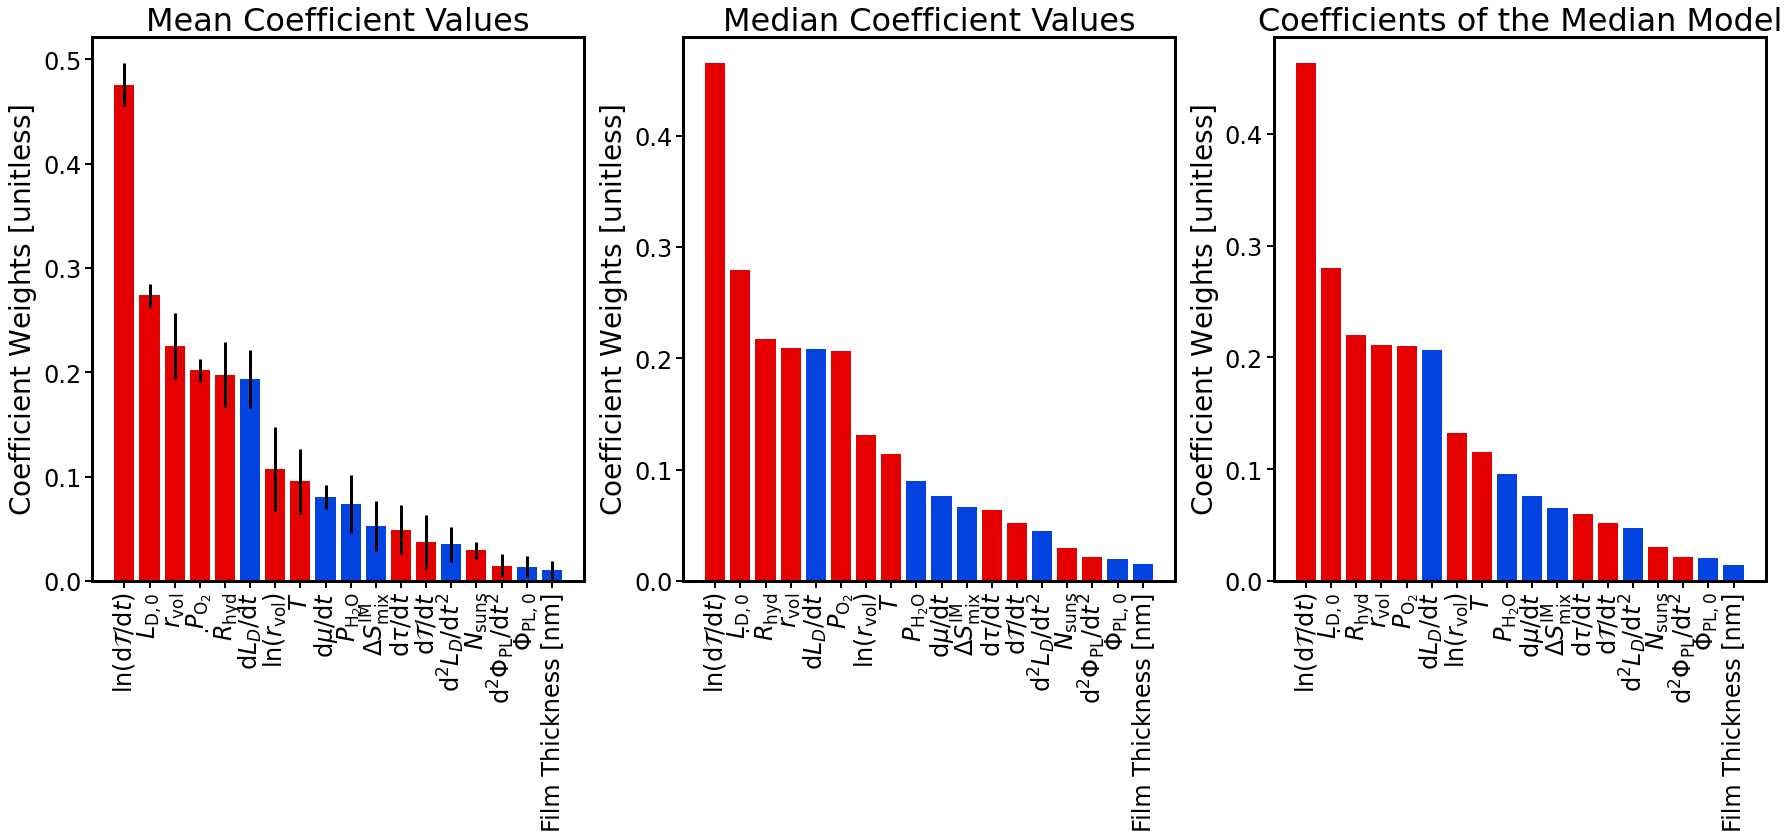

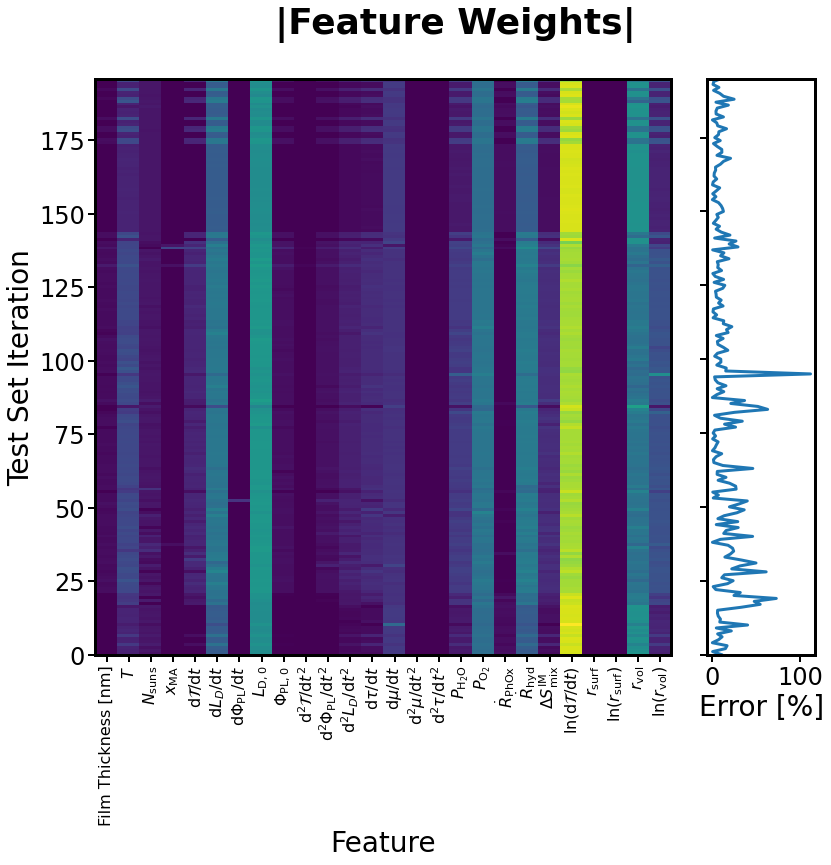

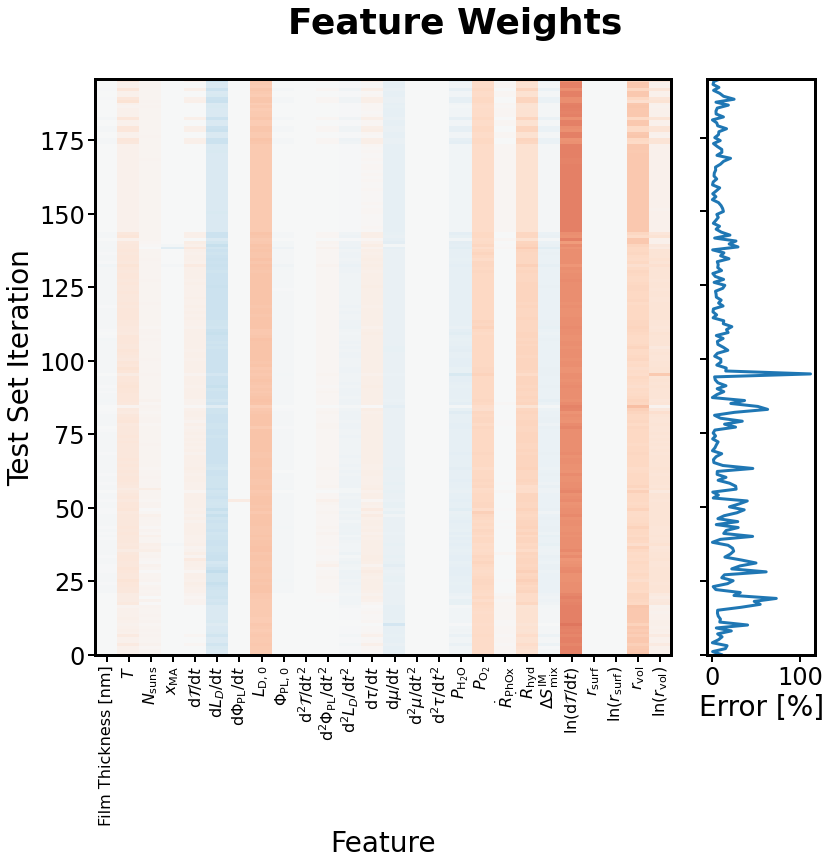

In [9]:
# make a copy of the coeffs_df but with Boolean values to indicate whether the corresponding feature was selected
selected_df = coeffs_df.copy()

for ii in range(len(selected_df)):
    logic = selected_df.iloc[ii] != 0 # convert nonzero values to True, zero values to False
    selected_df.iloc[ii] = logic

# make a DF of key statistics on the coefficient values
stats_df = coeffs_df.copy()

# initialize lists of key stats
medians = []
means = []
stds = []

# populate the lists...
for col in coeffs_df.columns:
    medians.append(np.median(coeffs_df[col]))
    means.append(np.mean(coeffs_df[col]))
    stds.append(np.std(coeffs_df[col]))
# ...and add them to the DataFrame 
stats_df.loc['medians'] = medians
stats_df.loc['means'] = means
stats_df.loc['stds'] = stds

# plot the median values of the coefficients
#plt.figure(figsize=(10,10))
#plt.bar(stats_df.columns,stats_df.loc['medians'])
#plt.xticks(rotation=90)

# assign bar colors to mean coefficient values
bar_colors_mean = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs)):
        if np.sign(means[jj]) == 1:
            bar_colors_mean.append('xkcd:red')
        else:
            bar_colors_mean.append('xkcd:blue')
else:
    for jj in range(len(coeffs)):
        if np.sign(avgs[jj]) == 1:
            bar_colors_mean.append('xkcd:blue')
        else:
            bar_colors_mean.append('xkcd:red')

# assign bar colors to median coefficient values
bar_colors_median = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs)):
        if np.sign(medians[jj]) == 1:
            bar_colors_median.append('xkcd:red')
        else:
            bar_colors_median.append('xkcd:blue')
else:
    for jj in range(len(coeffs)):
        if np.sign(medians[jj]) == 1:
            bar_colors_median.append('xkcd:blue')
        else:
            bar_colors_median.append('xkcd:red')

# make a dataFrame that will be used for bar plots specifically
bars_df = pd.DataFrame(means) # base it off the mean coefficient values
bars_df = bars_df.rename(columns={0:'means'})
bars_df['coeffs'] = coeffs # get coefficient names
bars_df.index = coeffs # make the DF indices equal to the coefficient names
bars_df['means'] = np.abs(bars_df['means']) # convert means to their absolute values for prettier/easier-to-read plots
bars_df['medians'] = np.abs(medians) # add median coefficient values
bars_df['error'] = stds # add standard deviations
bars_df['colors_mean'] = bar_colors_mean # encode coefficient sign in bar color
bars_df['colors_median'] = bar_colors_mean # encode coefficient sign in bar color
bars_df = bars_df.sort_values(by = 'means', ascending=False) # sort the bars in descending order of mean

# reduced dataframe of only coefficients with nonvanishing magnitude
nz_bars_df = bars_df[bars_df['means'] > 0]

# further reduced dataframe of only coefficients whose average is larger than their std. dev.
sig_bars_df = nz_bars_df[nz_bars_df['means'] > nz_bars_df['error']]

# for making plots look nice:
# dictionary for conversion of ASCII feature labels to TeX-style labels
fancy_labels_dict = {'dTrdt':'$\mathrm{d}\mathcal{T}/\mathrm{d}t$',
                     'lndTrdt':'ln($\mathrm{d}\mathcal{T}/\mathrm{d}t$)',
                     'dLDdt':'$\mathrm{d}L_D/\mathrm{d}t$',
                     'dPLdt':'$\mathrm{d}\Phi_\mathrm{PL}/\mathrm{d}t$',
                     'ddTr0':'$\mathrm{d^2}\mathcal{T}/\mathrm{d}t^2$',
                     'ddLD0':'$\mathrm{d}^2L_D/\mathrm{d}t^2$',
                     'ddPL0':'$\mathrm{d^2}\Phi_\mathrm{PL}/\mathrm{d}t^2$',
                     'dDFmeandt':'$\mathrm{d}\mu_\mathrm{DF}/\mathrm{d}t$',
                     'dtaudt':'$\mathrm{d}\\tau/\mathrm{d}t$',
                     'ddtau0':'$\mathrm{d^2}\\tau/\mathrm{d}t^2$',
                     'dmudt':'$\mathrm{d}\mu/\mathrm{d}t$',
                     'ddmu0':'$\mathrm{d^2}\mu/\mathrm{d}t^2$',
                     'Ld1':'$L_{\mathrm{D},t=1}$',
                     'Ld2':'$L_{\mathrm{D},t=2}$',
                     'Ld3':'$L_{\mathrm{D},t=3}$',
                     'Ld4':'$L_{\mathrm{D},t=4}$',
                     'Ld5':'$L_{\mathrm{D},t=5}$',
                     'Tr1':'$\mathcal{T}_{t=1}$',
                     'Tr2':'$\mathcal{T}_{t=2}$',
                     'Tr3':'$\mathcal{T}_{t=3}$',
                     'Tr4':'$\mathcal{T}_{t=4}$',
                     'Tr5':'$\mathcal{T}_{t=5}$',
                     'PL1':'$\Phi_{\mathrm{PL},t=1}$',
                     'PL2':'$\Phi_{\mathrm{PL},t=2}$',
                     'PL3':'$\Phi_{\mathrm{PL},t=3}$',
                     'PL4':'$\Phi_{\mathrm{PL},t=4}$',
                     'PL5':'$\Phi_{\mathrm{PL},t=5}$',
                     'PL0':'$\Phi_{\mathrm{PL},0}$',
                     'LD0':'$L_{\mathrm{D},0}$',
                     'QFLS_0':'$\Delta E_{\mathrm{F},0}$',
                     'Days Stored':'$t_{\mathrm{storage}}$',
                     'Temp':'$T$',
                     'P_H2O':'$P_\mathrm{H_2O}$',
                     'P_O2':'$P_\mathrm{O_2}$',
                     'Nsuns':'$N_\mathrm{suns}$',
                     'MA_frac':'$x_\mathrm{MA}$',
                     'PhotoOx_rate':'$\dot{R}_\mathrm{PhOx}$',
                     'Hydration_rate':'$\dot{R}_\mathrm{hyd}$',
                     'Ox_rate':'$\dot{R}_\mathrm{Ox}$',
                     'delS_mix':'$\Delta S^\mathrm{IM}_\mathrm{mix}$',
                     'LAI_O2':'$\\theta_\mathrm{O_2}$',
                     'Ox_rate_LAI':'$\\theta_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Ox_rate_P':'$P_\mathrm{O_2}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'Arrhenius_Ox':'$\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'PhotoOx_rate_P':'$P_\mathrm{O_2}N_\mathrm{suns}^{\gamma}\mathrm{exp}\left(-\\frac{E_\mathrm{a}}{k_\mathrm{B}T}\\right)$',
                     'ln_r':'ln($r_\mathrm{deg}$)',
                     'ln|dAdt|':'ln|$\mathrm{d}A/\mathrm{d}t$|',
                     'dAdt':'$\mathrm{d}A/\mathrm{d}t$',
                     'ddA0':'$\mathrm{d}^2 A/\mathrm{d}t^2$',
                     'ln|vol_rate|':'ln|$\\frac{1}{L}\mathrm{d}A/\mathrm{d}t$|',
                     'vol_rate':'$\\frac{1}{L}\mathrm{d}A/\mathrm{d}t$',
                     'd_vol_rate':'$\\frac{1}{L}\mathrm{d}^2A/\mathrm{d}t^2$',
                     'ln|meas_rate|':'ln|$r_\mathrm{vol}^\mathrm{meas}$|',
                     'meas_rate':'$r_\mathrm{vol}^\mathrm{meas}$',
                     'd_meas_rate':'$\\frac{\mathrm{d}}{\mathrm{d}t} \left[r_\mathrm{vol}^\mathrm{meas}\\right]$',
                     'ln|model_rate|':'ln|$r_\mathrm{vol}^\mathrm{model}$|',
                     'MAPI_degrate':'$r_\mathrm{surf}$',
                     'ln(MAPI_degrate)':'ln($r_\mathrm{surf}$)',
                     'MAPI_volrate':'$r_\mathrm{vol}$',
                     'ln(MAPI_volrate)':'ln($r_\mathrm{vol}$)',
                    }



# define list of nice-looking labels
fancy_labels=[]
for coeff in sig_bars_df['coeffs']:
    try:
        fancy_labels.append(fancy_labels_dict[coeff])
    except:
        fancy_labels.append(coeff)
        
# initialize the figure for comparing coefficients
fig, ax = plt.subplots(1,3,figsize=(30,10))  

# plot the means with error bars represented by the standard deviation
ax[0].bar(sig_bars_df['coeffs'],sig_bars_df['means'],yerr=sig_bars_df['error'],color=sig_bars_df['colors_mean'])
ax[0].set_xticklabels(labels=fancy_labels,rotation=90)
ax[0].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax[0].set_title('Mean Coefficient Values')

# now re-sort the DF by descending medians
bars_df = bars_df.sort_values(by = 'medians', ascending=False)

# reduced dataframe of only coefficients with nonvanishing magnitude
nz_meds_df = bars_df[bars_df['medians'] > 0]

# redefine the fancy coefficients
fancy_labels=[]
for coeff in nz_meds_df['coeffs']:
    try:
        fancy_labels.append(fancy_labels_dict[coeff])
    except:
        fancy_labels.append(coeff)

# and plot the median coefficient weights
ax[1].bar(nz_meds_df['coeffs'],nz_meds_df['medians'],color=nz_meds_df['colors_median'])
ax[1].set_xticklabels(labels=fancy_labels,rotation=90)
ax[1].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax[1].set_title('Median Coefficient Values')

# identify the index corresponding to the median model
idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
med_idx = idx # save the median index in a less ambiguous form
coeffs_med_model = coeffs_df.iloc[med_idx].values # extract corresponding coefficients

# assign bar colors to coefficient values
bar_colors_med_model = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs_med_model)):
        if np.sign(coeffs_med_model[jj]) == 1:
            bar_colors_med_model.append('xkcd:red')
        else:
            bar_colors_med_model.append('xkcd:blue')
else:
    for jj in range(len(coeffs_med_model)):
        
        if np.sign(coeffs_med_model[jj]) == 1:
            bar_colors_med_model.append('xkcd:blue')
        else:
            bar_colors_med_model.append('xkcd:red')

# make a DataFrame for bar plotting of the median model's coefficients
med_model_bars_df = pd.DataFrame(coeffs_med_model) 
med_model_bars_df = med_model_bars_df.rename(columns={0:'abs. values'})
med_model_bars_df['coeffs'] = coeffs_df.columns # get coefficient names
med_model_bars_df.index = coeffs # make the DF indices equal to the coefficient names
med_model_bars_df['colors'] = bar_colors_med_model # encode coefficient sign in bar color
med_model_bars_df['abs. values'] = np.abs(med_model_bars_df['abs. values'])
med_model_bars_df = med_model_bars_df.sort_values(by = 'abs. values', ascending=False) # sort the bars in descending order of mean

# identify the nonzero coefficients
sig_bars_med_model = med_model_bars_df.copy()[med_model_bars_df['abs. values'] > 0]

# redefine the fancy coefficients
fancy_labels=[]
for coeff in sig_bars_med_model['coeffs']:
    try:
        fancy_labels.append(fancy_labels_dict[coeff])
    except:
        fancy_labels.append(coeff)

# and make the plot
ax[2].bar(fancy_labels,sig_bars_med_model['abs. values'],color=sig_bars_med_model['colors'])
ax[2].set_xticklabels(fancy_labels,rotation=90)
ax[2].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax[2].set_title('Coefficients of the Median Model')



# make a figure with all the coefficients in a heat map
fig = plt.figure(figsize=(10,10))

# redefine the fancy coefficients
fancy_labels=[]
for coeff in coeffs_df.columns:
    try:
        fancy_labels.append(fancy_labels_dict[coeff])
    except:
        fancy_labels.append(coeff)

# first panel: heat map
ax1 = fig.add_axes([0,0,0.8,0.8])
ax1.pcolor(np.abs(coeffs_df))
ax1.set_xticks(np.arange(0.5, len(coeffs_df.columns), 1))
ax1.set_xticklabels(fancy_labels,rotation=90,fontsize=16)
ax1.set_xlabel('Feature')
ax1.set_ylabel('Test Set Iteration')

# plot of error with same y-axis
ax2 = fig.add_axes([0.85,0,0.15,0.8])
ax2.plot(MAE_pct,range(len(MAE_pct)))
ax2.set_ylim([np.min(range(len(MAE_pct))),np.max(range(len(MAE_pct)))])
ax2.set_yticklabels([])
ax2.set_xlabel('Error [%]',fontsize=28)
fig.suptitle('|Feature Weights|', x=0.5, y=0.9, fontsize=36, weight='bold')


# make a figure with all the coefficients in a DIVERGING heat map
fig2 = plt.figure(figsize=(10,10))

# redefine the fancy coefficients
fancy_labels=[]
for coeff in coeffs_df.columns:
    try:
        fancy_labels.append(fancy_labels_dict[coeff])
    except:
        fancy_labels.append(coeff)

# first panel: heat map
ax1 = fig2.add_axes([0,0,0.8,0.8])
ax1.pcolor(coeffs_df, cmap = 'RdBu', vmin = -1, vmax = 1)
ax1.set_xticks(np.arange(0.5, len(coeffs_df.columns), 1))
ax1.set_xticklabels(fancy_labels,rotation=90,fontsize=16)
ax1.set_xlabel('Feature')
ax1.set_ylabel('Test Set Iteration')

# plot of error with same y-axis
ax2 = fig2.add_axes([0.85,0,0.15,0.8])
ax2.plot(MAE_pct,range(len(MAE_pct)))
ax2.set_ylim([np.min(range(len(MAE_pct))),np.max(range(len(MAE_pct)))])
ax2.set_yticklabels([])
ax2.set_xlabel('Error [%]',fontsize=28)
fig2.suptitle('Feature Weights', x=0.5, y=0.9, fontsize=36, weight='bold')

# 6. Visualization

Put together parity plot and coefficients for the test-train split corresponding to the model with median error, and plot the test error distribution

<ipython-input-10-f215281b7491>:208: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2][0].set_xticklabels(fancy_labels,rotation=90)


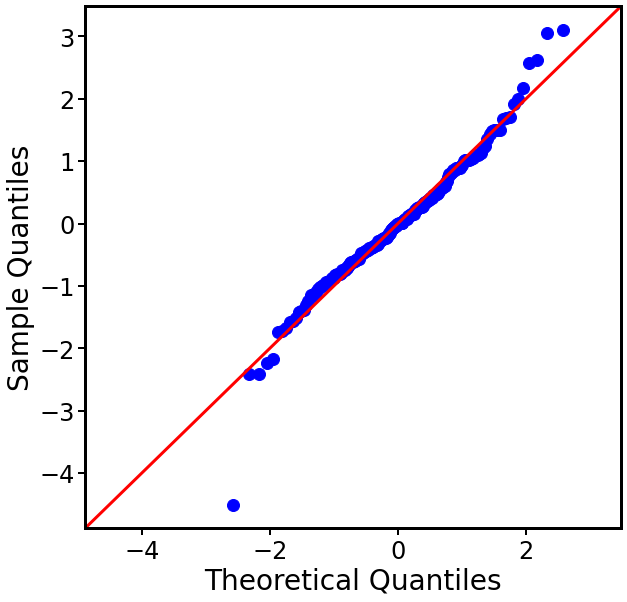

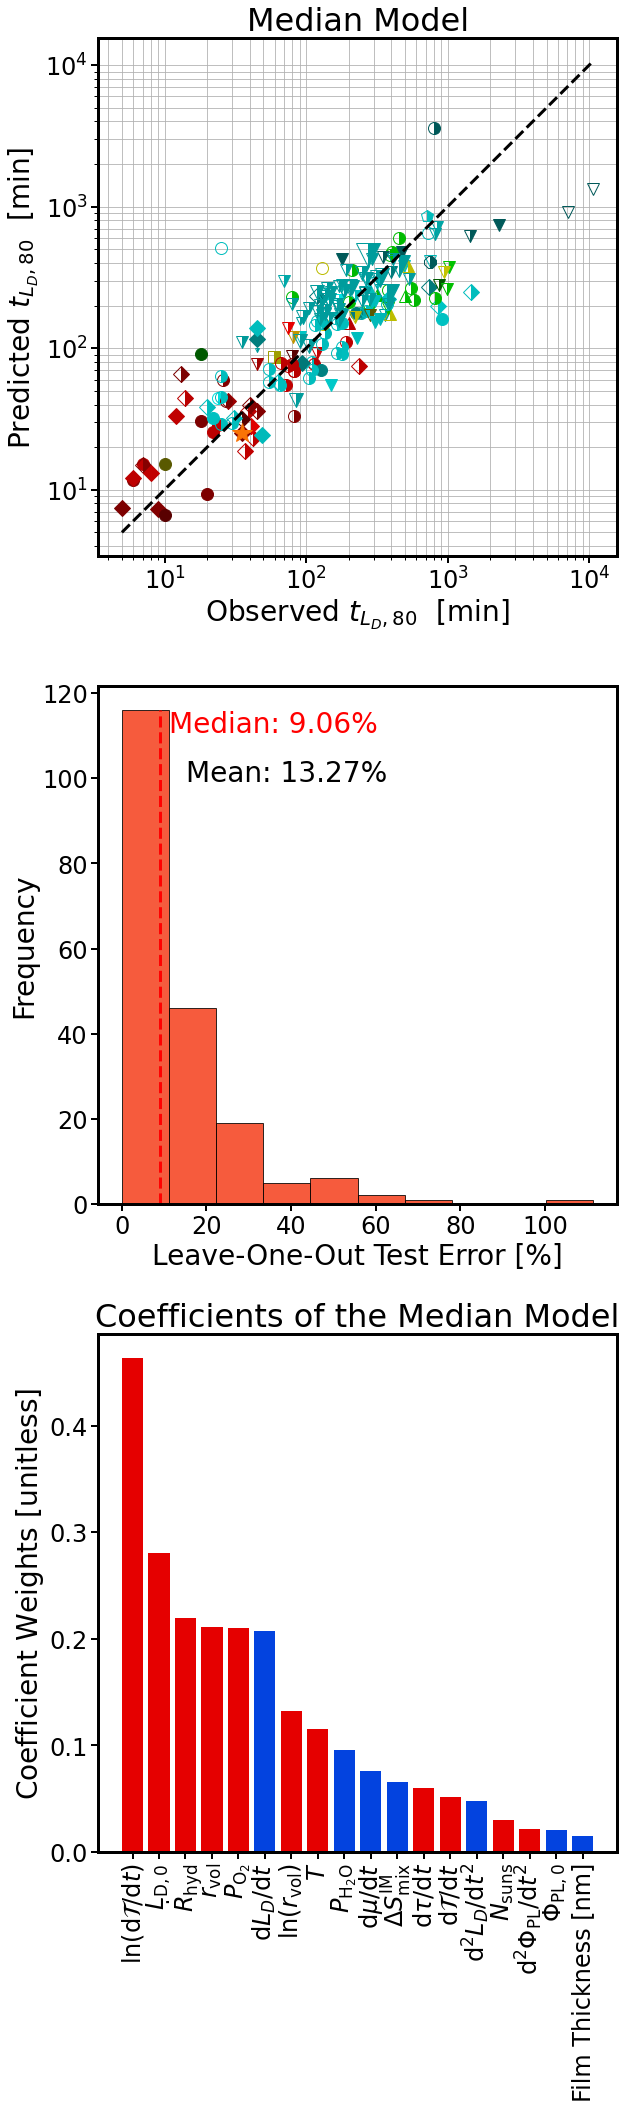

<Figure size 691.2x691.2 with 0 Axes>

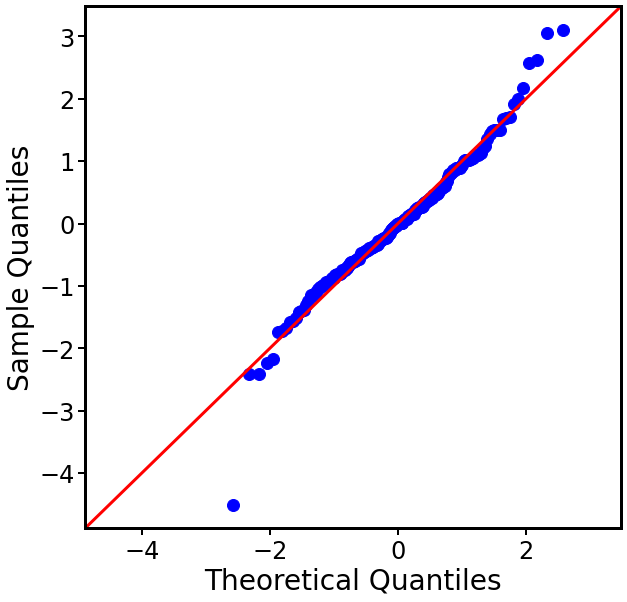

In [10]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import LogFormatter

# Make fancy plots of test set error 

# Set up the subplot parameters - again we want square panels not square subplots, so we do things manually
panel_size = 9 # absolute size of a single panel, inches(?)
n_plots_x = 3 # how many panels to plot in the x-direction
n_plots_y = 1 # how many panels to plot in the y-direction
aspect_ratio = n_plots_y/n_plots_x # overall aspect ratio of the figure
aspect_x = 1/n_plots_x
aspect_y = 1/n_plots_y


# turn panel labels (a,b,c,...) on or off
panel_labels = False

# create the figure
fig = plt.figure(figsize=(n_plots_x*panel_size,n_plots_y*panel_size))
ax_size = 0.8 # fraction of panel to plot axes
spacing = (1-ax_size)/2 # offset of axes from panel edge

ax = [] # initialize list of axes
for ii in range(n_plots_x):
    row_panel_list = []
    for jj in range(n_plots_y):
        row_panel_list.append(fig.add_axes([(jj+spacing)*aspect_x,1-(ii+1)*aspect_y+spacing*aspect_y, aspect_x*ax_size,aspect_y*ax_size]))
    ax.append(row_panel_list)



##### TOP LEFT: parity plot of median model
actual_all = []
preds_all = []
idxs_all = []

# plot training set
for ii in range(len(y_train)):
    idx = y_train.index[ii]
    T = featdata_df['Temp (deg C)'][idx]
    RH = featdata_df['RH (%)'][idx]
    pct_O2 = featdata_df['Oxygen (%)'][idx]
    N_suns_stress = featdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = featdata_df['MA fraction'][idx]
    thick = featdata_df['Film Thickness [nm]'][idx]
    encap = 'none'
    m_size = math.floor(thick/50)*2 + 2
    
    actual_all.append(y_train.loc[idx])
    preds_all.append(ytpred[ii])
    idxs_all.append(idx)
    if Log_transform:
        ax[0][0].loglog(np.exp(y_train.loc[idx]),np.exp(ytpred[ii]),
                        color=color,
                        marker=marker,
                        fillstyle=fill,linestyle=style,
                        markersize=m_size)   
    else:
        ax[0][0].plot(y_train.loc[idx],ytpred[ii],color=batch_colors[featdata_df['BatchID'][idx]],
                      marker=batch_markers[featdata_df['BatchID'][idx]],
                      fillstyle='full',linestyle=style,
                      markersize=m_size)

# plot perfect prediction line and +/-50% error bounds (latter good for DOE presentations, bad for publications)
if Log_transform:
    plotRange = np.linspace(np.exp(np.min(y_train)),np.exp(np.max(y_train)),num=2)
    ax[0][0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
    formatter = LogFormatter(labelOnlyBase=False, minor_thresholds=(2, 0.4))
    ax[0][0].grid(which='both')
else:
    plotRange = np.linspace(np.min(y_train),np.max(y_train),num=101)
    ax[0][0].plot(plotRange,plotRange,color='k',marker = ' ',linestyle='--')
#ax[0][0].plot(plotRange,plotRange+np.log(1.5),color='r',marker = ' ',linestyle='--')
#ax[0][0].plot(plotRange,plotRange+np.log(0.5),color='r',marker = ' ',linestyle='--')

# set appropriate axis labels and title
if response == 'tLD75 (min)':
    ax[0][0].set_xlabel('$\mathrm{Observed}\ \mathrm{ln}(t_{L_D,75}$)')
    ax[0][0].set_ylabel('$\mathrm{Predicted}\ \mathrm{ln}(t_{L_D,75}$)')
elif 'tLD80' in response:
    ax[0][0].set_xlabel('$\mathrm{Observed}\ t_{L_D,80}$  [min]')
    ax[0][0].set_ylabel('$\mathrm{Predicted}\ t_{L_D,80}$  [min]')
elif 'tLDmax' in response:
    ax[0][0].set_xlabel('$\mathrm{Observed}\ t_{L_D\mathrm{,max}}$  [min]')
    ax[0][0].set_ylabel('$\mathrm{Predicted}\ t_{L_D\mathrm{,max}}$  [min]')
elif 'tPLmax' in response:
    ax[0][0].set_xlabel('$\mathrm{Observed}\ t_{\mathrm{PL,max}}$  [min]')
    ax[0][0].set_ylabel('$\mathrm{Predicted}\ t_{\mathrm{PL,max}}$  [min]')
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    ax[0][0].set_xlabel('$\mathrm{Observed\ ln(Bleaching\ Rate})$')
    ax[0][0].set_ylabel('$\mathrm{Predicted\ ln(Bleaching\ Rate)}$')
elif response == 'tA80' :
    ax[0][0].set_xlabel('Observed $t_{A,80} [min]$')
    ax[0][0].set_ylabel('Predicted $t_{A,80} [min]$')
ax[0][0].set_title('Median Model')

# plot test data as above
for ii in range(len(y_whold)):
    idx = y_whold.index[ii]
    T = featdata_df['Temp (deg C)'][idx]
    RH = featdata_df['RH (%)'][idx]
    pct_O2 = featdata_df['Oxygen (%)'][idx]
    N_suns_stress = featdata_df['Illum (Nsuns)'][idx]
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,encap)
    MA_frac = featdata_df['MA fraction'][idx]
    thick = featdata_df['Film Thickness [nm]'][idx]
    encap = 'none'
    m_size = math.floor(thick/50)*2 + 2
    
    actual_all.append(y_whold.loc[idx])
    preds_all.append(ypred[ii])
    idxs_all.append(idx)
    
    if Log_transform:
        ax[0][0].loglog(np.exp(y_whold[idx]),np.exp(ypred[ii]),
                        color=color,
                        marker=marker,
                        fillstyle=fill,linestyle=style,
                        markersize=m_size)
        # test sample in orange
        ax[0][0].loglog(np.exp(y_whold[idx]),np.exp(ypred[ii]),
                        marker='*',markersize=20,color='xkcd:orange')
    
    else:
        ax[0][0].plot(y_whold[idx],ypred[ii],color=color,
                        marker=marker,
                        fillstyle=fill,linestyle=style,
                      markersize=m_size)
        # test sample in orange
        ax[0][0].plot(y_whold[idx],ypred[ii],marker='*',markersize=20,color='xkcd:orange')

# plot legend for test sample
#if response == 'tLD75 (min)':
#    ax[0][0].plot(5,2,marker='*',markersize=20,color='xkcd:orange')
#    ax[0][0].text(5.2,1.98,'Test Sample',fontsize=20,weight='bold',color='xkcd:orange',va='center')
  
# calculate error metrics
actual_all = np.array(actual_all)
preds_all = np.array(preds_all)
R2_overall = r2_score(actual_all,preds_all)
MAE_pct_overall = np.abs((preds_all - actual_all)/preds_all)*100
    
# set text position for the approporiate response variable
if response == 'tLD75 (min)':
    text_x = 2
    text_y = 6
elif response == 'Bleach Rate (fit to 5% inc) (1/min)' :
    text_x = -9
    text_y = -4
    


##### BOTTOM LEFT: test set error distribution
ax[1][0].hist(MAE_pct,color='xkcd:vermillion',alpha=0.8,edgecolor='black',histtype='bar')
ax[1][0].set_xlabel('Leave-One-Out Test Error [%]')
ax[1][0].set_ylabel('Frequency')
ax[1][0].vlines(np.median(MAE_pct),0,np.max(np.histogram(MAE_pct)[0]),color='r',linestyle='--')
ax[1][0].text(np.median(MAE_pct)+2,np.max(np.histogram(MAE_pct)[0]),
              'Median: '+str(round(np.median(MAE_pct),2))+'%',color='r',va='top')
ax[1][0].text(np.mean(MAE_pct)+2,0.9*np.max(np.histogram(MAE_pct)[0]),
              'Mean: '+str(round(np.mean(MAE_pct),2))+'%',color='k',va='top')

##### BOTTOM RIGHT: coefficients of the median model

# identify the index corresponding to the median model
idx = np.argmin(np.abs(MAE_pct-np.median(MAE_pct)))
med_idx = idx # save the median index in a less ambiguous form
coeffs_med_model = coeffs_df.iloc[med_idx].values # extract corresponding coefficients

# assign bar colors to coefficient values
bar_colors_med_model = []
if response == 'Bleach Rate (fit to 5% inc) (1/min)':
    for jj in range(len(coeffs_med_model)):
        if np.sign(coeffs_med_model[jj]) == 1:
            bar_colors_med_model.append('xkcd:red')
        else:
            bar_colors_med_model.append('xkcd:blue')
else:
    for jj in range(len(coeffs_med_model)):
        if np.sign(coeffs_med_model[jj]) == 1:
            bar_colors_med_model.append('xkcd:blue')
        else:
            bar_colors_med_model.append('xkcd:red')

# make a DataFrame for bar plotting of the median model's coefficients
med_model_bars_df = pd.DataFrame(coeffs_med_model) 
med_model_bars_df = med_model_bars_df.rename(columns={0:'abs. values'})
med_model_bars_df['coeffs'] = coeffs_df.columns # get coefficient names
med_model_bars_df.index = coeffs # make the DF indices equal to the coefficient names
med_model_bars_df['colors'] = bar_colors_med_model # encode coefficient sign in bar color
med_model_bars_df['abs. values'] = np.abs(med_model_bars_df['abs. values'])
med_model_bars_df = med_model_bars_df.sort_values(by = 'abs. values', ascending=False) # sort the bars in descending order of mean

# identify the nonzero coefficients
sig_bars_med_model = med_model_bars_df[med_model_bars_df['abs. values'] > 0]

# redefine the fancy coefficients
fancy_labels=[]
for coeff in sig_bars_med_model['coeffs']:
    try:
        fancy_labels.append(fancy_labels_dict[coeff])
    except:
        fancy_labels.append(coeff)

# and make the plot
ax[2][0].bar(fancy_labels,sig_bars_med_model['abs. values'],color=sig_bars_med_model['colors'])
ax[2][0].set_xticklabels(fancy_labels,rotation=90)
ax[2][0].set_ylabel('$\mathrm{Coefficient\ Weights\ [unitless]}$')
ax[2][0].set_title('Coefficients of the Median Model')

# add grand title and panel labels if desired
#fig.suptitle('Early-Time + Linear Env\'t and Comp. Features', x=0.5, y=1, fontsize=48, weight='bold')
if panel_labels:
    fig.text(0,0.9,'a',fontsize=36,weight='bold')
    fig.text(0,-0.1,'b',fontsize=36,weight='bold')
    fig.text(0,-1.1,'c',fontsize=36,weight='bold')

### Uncomment the linest below to see corners of the figure
#fig.text(0,0,'(0,0)')
#fig.text(1,0,'(1,0)')
#fig.text(0,1,'(0,1)')
#fig.text(1,1,'(1,1)')

residuals = actual_all-preds_all

std_resids = (residuals-np.mean(residuals))/np.std(residuals)
# initialize axis for qq plot
new_fig = plt.figure()
import statsmodels.api as sm
sm.qqplot(std_resids,line='45')


# 7. Conformal Prediction

Use the Jackknife+ algorithm to establish confidence intervals and look at test reproducibility

## BEWARE: This block has to train n(n-1)/2 (= almost 5000 if n=100) models, so it takes forever (~2 hours) to run. Use wisely.


In [34]:
##### Regenerate the dataset with all the features

# full dataset: features + response
terms_to_keep = chosen_features + [response]

# make a copy of the dataframe so that irrelevant responses can be removed
coded_df = featdata_df.copy()
print('Number of Runs Total:',len(coded_df))

# If what we are trying to predict is a failure time (e.g., tLD75, tPL10, etc.),
# throw out runs that fail before the prediction interval has finished
# or all runs that take 10 min or less
if response[0] == 't':
    coded_df = coded_df[coded_df['pred_horiz']*5.0/6.0 < coded_df[response]]
    #coded_df = coded_df[10 <= coded_df[response]]
print('Number of Runs That Fail After Prediction Horizon:',len(coded_df))

# encode feature names to simplify interaction calculations
coded_df.rename(columns = factor_dict_inv, inplace = True)
# drop responses that we're not interested in
cols_to_drop = diff(list(coded_df.columns),terms_to_keep)
coded_df = coded_df.drop(columns=cols_to_drop)

# drop rows containing NaNs
coded_df = coded_df.dropna(axis=0)

if Log_transform:
    Y = np.log(np.abs(coded_df[response])).copy() # BE VERY CAREFUL NOT TO UNINTENTIONALLY CHANGE THE DATAFRAME
else:
    Y = coded_df[response].copy()
X = coded_df.drop(columns=response).copy()

# number of runs in dataset - for leave-one-out testing this is the size of the dataset
n_trials = len(Y)

# set up search parameters for cross-validation, which will be used to select the hyperparameter
param_vals = np.logspace(-3,3,num=31) # range of hyperparameters to test
parameters = {'alpha': param_vals}
model = Lasso(max_iter=1e9) # model to implement - LASSO, Ridge, etc.
metric = 'neg_mean_squared_error' # scoring metric - MSE, R2, etc.
folds = len(Y)-2 # how many folds to do in k-fold cross-validation - 5 is standard


##### Start the Jackknife+ algorithm

# initialize matrices containing summary data
fij = np.zeros([n_trials,n_trials]) # prediction on sample i holding out samples i and j
fji = np.zeros([n_trials,n_trials]) # prediction on sample j holding out samples i and j
Rij = np.zeros([n_trials,n_trials]) # residual on sample i holding out samples i and j
Rji = np.zeros([n_trials,n_trials]) # residual on sample j holding out samples i and j


# Outer loop: iterate over samples in the test set
for j in range(n_trials):
    
    # do test/train split by pulling out one row at a time form the feature and response DFs
    # CAREFUL WITH THE INDEXING - note differences between the test/withhold and training sets
    # ALSO: COPY THE SUBSETS Of THE DATAFRAMES or the values in the source will change and the 
    # prediction will be unstable and the whole thing will be ruined
    X_whold = X.iloc[j].copy()
    y_whold = Y.iloc[j:j+1].copy()
    X_train = X.drop(X.index[j]).copy()
    y_train = Y.drop(X.index[j]).copy()
    
    # standardize the data according to the mean and variance of each feature in the training dataset
    for col in X_train.columns:
        # get mean and variance of features in the test set
        col_mean = np.mean(X_train[col])
        col_std = np.std(X_train[col])
        # standardize the features in the training set
        z_train = (X_train[col] - col_mean)/col_std
        X_train[col] = z_train
        # standardize the features in the test set
        z_whold = (X_whold[col] - col_mean)/col_std
        X_whold[col] = z_whold
    
    # Inner loop: hold samples out one at a time from the training set
    for i in range(j):
        
        # keep track of things
        print('Holding out samples',(i,j))
        
        # partition training and test sets again
        X_val = X_train.iloc[i].copy()
        y_val = y_train.iloc[i:i+1].copy()
        X_val_train = X_train.drop(X_train.index[i]).copy()
        y_val_train = y_train.drop(y_train.index[i]).copy()

        # cross-validation step to set alpha/lambda/penalty hyperparameter
        regressor = GridSearchCV(model,parameters,scoring=metric,cv=folds)
        regressor.fit(X_val_train,y_val_train)

        # print winning HP value if desired...
        print(regressor.best_params_)
        #print(regressor.best_score_)
        alpha = regressor.best_params_['alpha']

        # ...and retrain the final model on the full training set
        # mu_ij: model trained holding samples i and j out
        mu_ij = Lasso(alpha=alpha)
        mu_ij.fit(X_val_train,y_val_train)
        #print(final_model.coef_)

        # make predictions on the test and training data
        ypred=mu_ij.predict(np.array(X_val).reshape(1,-1))
        ytpred=mu_ij.predict(X_val_train)         
        
        # test predictions on held-out samples i and j
        fij[i,j] = mu_ij.predict(np.array(X_val).reshape(1,-1))
        fji[j,i] = mu_ij.predict(np.array(X_whold).reshape(1,-1))
        
        # calculate residuals on those predictions
        Rij[i,j] = np.abs(y_val - fij[i,j])
        Rji[j,i] = np.abs(y_whold - fji[j,i])



Number of Runs Total: 275
Number of Runs That Fail After Prediction Horizon: 240
Holding out samples (0, 1)


KeyboardInterrupt: 

# 8. Conformal Prediction - Visualization

Use this block to look at the results from conformal prediction.


In [ ]:
alpha = 0.05 # parameter for determining quantiles for CI

# construct full residual and prediction matrices
F = fij + fji
R = Rij + Rji

# initialize lower and upper bounds bound of CI
L = np.zeros(n_trials)
U = np.zeros(n_trials)

uppers = F + R
lowers = F - R

medians = np.zeros(n_trials)
means = np.zeros(n_trials)
stds = np.zeros(n_trials)

# loop over all predictions
for i in range(n_trials):
    
    # get rid of the zeros on the diagonal
    up = list(uppers[i,:]) # upper CI bound
    up = up[:i] + up[i+1:]
    lo = list(lowers[i,:]) # lower CI bound
    lo = lo[:i] + lo[i+1:]
    f = list(F[i,:]) # predictions
    f = f[:i] + f[i+1:]
    
    # sort the upper and lower residual distributions 
    up.sort()
    lo.sort()
    
    # calculate the quantiles and add them to the arrays
    L[i] = np.quantile(lo,alpha)
    U[i] = np.quantile(up,1-alpha)
    
    #calculate stats
    medians[i] = np.median(f)
    means[i] = np.mean(f)
    stds[i] = np.std(f)
    
# make a parity plot with CIs

fig,ax = plt.subplots(figsize=(15,15))
ax.errorbar(Y,medians,xerr=[medians-L,U-medians],marker='',linestyle='',fmt='k-',elinewidth=0.75,capsize=5)
    
for i in range(len(medians)):
    idx = Y.index[i] # pull the corresponding index in the DF
    T = featdata_df['Temp (deg C)'][idx] # get temperature
    RH = featdata_df['RH (%)'][idx] # get relative humidity
    pct_O2 = featdata_df['Oxygen (%)'][idx] # get oxygen mole fraction
    N_suns_stress = featdata_df['Illum (Nsuns)'][idx] # get illumination
    color, marker, fill, style = envt_plot_style(T,RH,pct_O2,N_suns_stress,'none')
    
    asym_error = [-(medians[i]-L[i]),U[i]-medians[i]]
    
    ax.plot(Y.iloc[i],medians[i],color=color,marker=marker,fillstyle=fill,linestyle=style)
    #ax.errorbar(Y.iloc[i],medians[i],xerr=np.array(asym_error),color=color,marker=marker,fillstyle=fill,linestyle=style)
    
    
x = np.linspace(1,8,num=2)
ax.plot(x,x,'k--')
ax.set_xlabel('Observed ln($t_{L_D,75}$)')
ax.set_ylabel('Predicted ln($t_{L_D,75}$)')
ax.set_title('Jackknife+: 90% Prediction Intervals')